### Import

In [1]:
import pickle
import time
import numpy as np
from matplotlib import pyplot as plt
import os#Work with filepaths
import cv2#Open Cv
import mediapipe as mp
#To split data for training and testing 
from sklearn.model_selection import train_test_split
#To convert data into one encoded data
from tensorflow.keras.utils import to_categorical
#Importing sequential model,LSTM layer and dense layer
from tensorflow.keras.models import Sequential #Allows us to build sequential neural model
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import TensorBoard
#tensorboard --logdir=. use this to check logs
#It allows us to logging inside tensorboard to trace and moniter our model as it is training
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import statistics
import math

### Taking keypoints using mediapipe hand_landmarks

In [2]:
#Media pipe Hands to make hand detection
#Media pipe drawing will draw those points
#We will create them as function to easily access them
mp_hands = mp.solutions.hands
mp_drawing=mp.solutions.drawing_utils#Drawing the utilites

In [3]:
#Creating mediapipe detection function
def mediapipe_detection(image,model):
    #To the function we pass image and holistic model for detection
    #So when wwe get feed from opencv it is of format bgr(blue,green,red)
    #For detection we need them to be rgb we will change that using opencv
    #Here image is the frames from opencv
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)#Color conversion
    image.flags.writeable=False#Image is no longer writeable
    results=model.process(image)#Making detection
    image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)#Color conversion
    image.flags.writeable=True#Image is writeable again
    return image,results #Returning the results

In [4]:
#Formatted draw style landmarks
def draw_styled_landmarks(image,result):
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(image,hand_landmarks,mp_hands.HAND_CONNECTIONS,
                                      #color landmark
                                      mp_drawing.DrawingSpec(color=(245,117,66),thickness=2,circle_radius=4)
                                      #color connections
                                      ,mp_drawing.DrawingSpec(color=(245,66,230),thickness=2,circle_radius=2))

In [5]:
#Shows coordinates for each point with names SDVWRDVWS this
def print_points(results):
    if results.multi_hand_landmarks:
        for hand_no, hand_landmarks in enumerate(results.multi_hand_landmarks):#Loop through no of hands
            print(f'HAND NUMBER: {hand_no+1}')
            print('-----------------------')
        
        for i in range(21):#Lopp through Points
            print(f'{mp_hands.HandLandmark(i).name}:')#Loops through each points in hand
            print(f'{hand_landmarks.landmark[mp_hands.HandLandmark(i).value]}')#Coordinates

In [6]:
print(f'{mp_hands.HandLandmark(10).name}:')

MIDDLE_FINGER_PIP:


In [7]:
#Bounding Box
x_list = []
y_list = []
bbox = []
def bounding_box(img,results):
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            for lnmarks in hand_landmarks.landmark:
                h, w, c = img.shape  # We get height,width and no of color channels used in the image
                cx, cy = int(lnmarks.x * w), int(
                    lnmarks.y * h)  # here we get exact value of the points located in the image
                x_list.append(cx)
                y_list.append(cy)
        xmin, xmax = min(x_list), max(x_list)
        ymin, ymax = min(y_list), max(y_list)
        bbox = xmin, ymin, xmax, ymax#Coordinates for the box
        cv2.rectangle(img, (xmin - 10, ymin - 10), (xmax + 10, ymax + 10),
                              (0, 255, 0), 2)
        x_list.clear()#To have fresh coordintes for each frame
        y_list.clear()

In [8]:
#Finding Distance
def findDistance(x1,x2,y1,y2):  # Finds distance between two fingers
        length = math.hypot(x2 - x1, y2 - y1)
        return length

In [9]:
#Find distance in y points
def findDistance_y(y1,y2):
    length=math.pow((y2-y1),2)
    return length

In [11]:
#Accessing video through webcm using OpenCV
#We loop thorugh all frames in camera to create video
cap=cv2.VideoCapture(0)#To acccess our webcam 
#here 0 represents device

#Accessing the holistic model
with mp_hands.Hands(static_image_mode=True,max_num_hands=2,min_detection_confidence=0.5) as hands:
    # only static images,max 2 hand detection
    while cap.isOpened():#It checks wheather we are accessing or not
        #Read feed
        ret,frame=cap.read()#It reads our frames
        
        #Make detections
        image,results=mediapipe_detection(frame,hands)
        #Drwing Landmarks
        draw_styled_landmarks(image,results)
        print_points(results)
        print(extract_keypoints(results,image))
        bounding_box(image,results)#To print a Box around the Hand
        #To showw to screen
        #Rendering
        cv2.imshow("OpenCv Feed",image)

        #To Exit o break the feed
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break #it waits and if we press q breaks the loop
    cap.release()#It releases the webcam
    cv2.destroyAllWindows()#Destroy the cv window

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
HAND NUMBER: 1
-----------------------
WRIST:
x: 0.3011481463909149
y: 0.5966444611549377
z: 6.313943572422431e-07

THUMB_CMC:
x: 0.3759336769580841
y: 0.6279323101043701
z: -0.0277151707559824

THUMB_MCP:
x: 0.44571933150291443
y: 0.7007980346679688
z: -0.05257365480065346

THUMB_IP:
x: 0.505605161190033
y: 0.7518795132637024
z: -0.0718032568693161

THUMB_TIP:
x: 0.5626671314239502
y: 0.7634260058403015
z: -0.09363935887813568

INDEX_FINGER_MCP:
x: 0.416620135307312
y: 0.7541910

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.3035374879837036
y: 0.6131139993667603
z: 6.864080432933406e-07

THUMB_CMC:
x: 0.38153114914894104
y: 0.6384792923927307
z: -0.03155786544084549

THUMB_MCP:
x: 0.4511406421661377
y: 0.7086576819419861
z: -0.05795400217175484

THUMB_IP:
x: 0.5100005269050598
y: 0.7630358934402466
z: -0.07775472104549408

THUMB_TIP:
x: 0.566788911819458
y: 0.7798041105270386
z: -0.09989531338214874

INDEX_FINGER_MCP:
x: 0.41578835248947144
y: 0.7707579135894775
z: -0.08941323310136795

INDEX_FINGER_PIP:
x: 0.4587842524051666
y: 0.874001145362854
z: -0.1273011565208435

INDEX_FINGER_DIP:
x: 0.485466867685318
y: 0.9444741010665894
z: -0.14904794096946716

INDEX_FINGER_TIP:
x: 0.506414532661438
y: 1.004063367843628
z: -0.16362518072128296

MIDDLE_FINGER_MCP:
x: 0.3642774820327759
y: 0.7917307615280151
z: -0.09291477501392365

MIDDLE_FINGER_PIP:
x: 0.37863895297050476
y: 0.9123451113700867
z: -0.12724711000919342

MIDDLE_FINGER_DIP:
x: 0.3857884109020233
y: 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
HAND NUMBER: 1
-----------------------
WRIST:
x: 0.2989828586578369
y: 0.6085037589073181
z: 6.785353434679564e-07

THUMB_CMC:
x: 0.37691909074783325
y: 0.6337318420410156
z: -0.03480600565671921

THUMB_MCP:
x: 0.44831645488739014
y: 0.7023013830184937
z: -0.06429275125265121

THUMB_IP:
x: 0.508633553981781
y: 0.7590025663375854
z: -0.08638346195220947

THUMB_TIP:
x: 0.56731116771698
y: 0.7834122776985168
z: -0.11024004220962524

INDEX_FINGER_MCP:
x: 0.412369042634964
y: 0.7585821747779846
z: -0.09902813285589218

INDEX_FINGER_PIP:
x: 0.45890289545059204
y: 0.8687372803688049
z: -0.1397177278995514

INDEX_FINGER_DIP:
x: 0.48727452754974365
y: 0.9444928169250488
z: -0.1611761450767517

INDEX_FINGER_TIP:
x: 0.5082011222839355
y: 1.006

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.2999400496482849
y: 0.6133792996406555
z: 6.659932410002511e-07

THUMB_CMC:
x: 0.37904465198516846
y: 0.6363938450813293
z: -0.03356873244047165

THUMB_MCP:
x: 0.4504879415035248
y: 0.7047532796859741
z: -0.0604960173368454

THUMB_IP:
x: 0.5101004838943481
y: 0.7622472643852234
z: -0.08049921691417694

THUMB_TIP:
x: 0.5669115781784058
y: 0.7866765260696411
z: -0.1022510752081871

INDEX_FINGER_MCP:
x: 0.41533875465393066
y: 0.766884446144104
z: -0.09318550676107407

INDEX_FINGER_PIP:
x: 0.460389107465744
y: 0.8766490817070007
z: -0.13214321434497833

INDEX_FINGER_DIP:
x: 0.48712319135665894
y: 0.9505671262741089
z: -0.15330515801906586

INDEX_FINGER_TIP:
x: 0.5072815418243408
y: 1.0125027894973755
z: -0.16685864329338074

MIDDLE_FINGER_MCP:
x: 0.362878680229187
y: 0.7893500924110413
z: -0.09523262828588486

MIDDLE_FINGER_PIP:
x: 0.3784520626068115
y: 0.9122642278671265
z: -0.13002072274684906

MIDDLE_FINGER_DIP:
x: 0.38873618841171265
y

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.29898354411125183
y: 0.611646831035614
z: 6.270036010391777e-07

THUMB_CMC:
x: 0.37724679708480835
y: 0.63730788230896
z: -0.03566885367035866

THUMB_MCP:
x: 0.4498148560523987
y: 0.7068716287612915
z: -0.06770531088113785

THUMB_IP:
x: 0.5120404958724976
y: 0.7636535167694092
z: -0.09202896058559418

THUMB_TIP:
x: 0.57097327709198
y: 0.7875582575798035
z: -0.11846616119146347

INDEX_FINGER_MCP:
x: 0.4148325026035309
y: 0.7610321640968323
z: -0.10763902962207794

INDEX_FINGER_PIP:
x: 0.46070396900177
y: 0.8718329071998596
z: -0.15238036215305328

INDEX_FINGER_DIP:
x: 0.4883025884628296
y: 0.9494655728340149
z: -0.17626632750034332

INDEX_FINGER_TIP:
x: 0.5082294940948486
y: 1.0134779214859009
z: -0.19123408198356628

MIDDLE_FINGER_MCP:
x: 0.3621826171875
y: 0.783058762550354
z: -0.10987421125173569

MIDDLE_FINGER_PIP:
x: 0.3777821362018585
y: 0.9100480079650879
z: -0.15036055445671082

MIDDLE_FINGER_DIP:
x: 0.38618049025535583
y: 0.999

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.29815390706062317
y: 0.6095345616340637
z: 6.247461215025396e-07

THUMB_CMC:
x: 0.3770105838775635
y: 0.6346418857574463
z: -0.03459881991147995

THUMB_MCP:
x: 0.4490675628185272
y: 0.7015432119369507
z: -0.0626148134469986

THUMB_IP:
x: 0.5085008144378662
y: 0.7590546011924744
z: -0.08358665555715561

THUMB_TIP:
x: 0.565202534198761
y: 0.7860807180404663
z: -0.10608699917793274

INDEX_FINGER_MCP:
x: 0.41228368878364563
y: 0.7637414932250977
z: -0.09572486579418182

INDEX_FINGER_PIP:
x: 0.4585402309894562
y: 0.8723896145820618
z: -0.13731132447719574

INDEX_FINGER_DIP:
x: 0.48820260167121887
y: 0.9461947679519653
z: -0.16022968292236328

INDEX_FINGER_TIP:
x: 0.5111546516418457
y: 1.0076698064804077
z: -0.1748812198638916

MIDDLE_FINGER_MCP:
x: 0.35932213068008423
y: 0.7881443500518799
z: -0.09757651388645172

MIDDLE_FINGER_PIP:
x: 0.3764246702194214
y: 0.9100267887115479
z: -0.13467323780059814

MIDDLE_FINGER_DIP:
x: 0.3890757858753204

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.29773566126823425
y: 0.6084350347518921
z: 6.95616449775116e-07

THUMB_CMC:
x: 0.37726715207099915
y: 0.6312757730484009
z: -0.036874920129776

THUMB_MCP:
x: 0.4493167996406555
y: 0.6989353895187378
z: -0.06565215438604355

THUMB_IP:
x: 0.509784460067749
y: 0.7581320405006409
z: -0.08659156411886215

THUMB_TIP:
x: 0.5677824020385742
y: 0.7854806184768677
z: -0.10907250642776489

INDEX_FINGER_MCP:
x: 0.4114742577075958
y: 0.7598299980163574
z: -0.10076767206192017

INDEX_FINGER_PIP:
x: 0.45826154947280884
y: 0.8742846250534058
z: -0.14182059466838837

INDEX_FINGER_DIP:
x: 0.4866431951522827
y: 0.9512538313865662
z: -0.16379253566265106

INDEX_FINGER_TIP:
x: 0.5080412030220032
y: 1.01546049118042
z: -0.17773887515068054

MIDDLE_FINGER_MCP:
x: 0.35781803727149963
y: 0.7836794257164001
z: -0.10114970058202744

MIDDLE_FINGER_PIP:
x: 0.37598368525505066
y: 0.908211886882782
z: -0.13870041072368622

MIDDLE_FINGER_DIP:
x: 0.3897354304790497
y:

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.29870954155921936
y: 0.6125711798667908
z: 6.741472020621586e-07

THUMB_CMC:
x: 0.378467857837677
y: 0.6362583637237549
z: -0.034888554364442825

THUMB_MCP:
x: 0.4507266879081726
y: 0.7044172883033752
z: -0.06297822296619415

THUMB_IP:
x: 0.5100443959236145
y: 0.7644308805465698
z: -0.08353158831596375

THUMB_TIP:
x: 0.5674542188644409
y: 0.7916265726089478
z: -0.1057736724615097

INDEX_FINGER_MCP:
x: 0.41454192996025085
y: 0.7597989439964294
z: -0.09734854102134705

INDEX_FINGER_PIP:
x: 0.4593495726585388
y: 0.8715901970863342
z: -0.136741504073143

INDEX_FINGER_DIP:
x: 0.48673784732818604
y: 0.9451968669891357
z: -0.15781357884407043

INDEX_FINGER_TIP:
x: 0.5077847838401794
y: 1.0066922903060913
z: -0.1712719351053238

MIDDLE_FINGER_MCP:
x: 0.3613131642341614
y: 0.7816627025604248
z: -0.09913820028305054

MIDDLE_FINGER_PIP:
x: 0.37844613194465637
y: 0.9059691429138184
z: -0.13533607125282288

MIDDLE_FINGER_DIP:
x: 0.3902783989906311


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
HAND NUMBER: 1
-----------------------
WRIST:
x: 0.30474013090133667
y: 0.4674735963344574
z: 6.482752041847561e-07

THUMB_CMC:
x: 0.3779584467411041
y: 0.49338841438293457
z: -0.03510172665119171

THUMB_MCP:
x: 0.456306338310

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.2962293028831482
y: 0.44359180331230164
z: 5.694605533790309e-07

THUMB_CMC:
x: 0.3688529431819916
y: 0.4660370349884033
z: -0.021457551047205925

THUMB_MCP:
x: 0.4264383912086487
y: 0.5258428454399109
z: -0.045502595603466034

THUMB_IP:
x: 0.4565354287624359
y: 0.5865446925163269
z: -0.06485096365213394

THUMB_TIP:
x: 0.4728447496891022
y: 0.6333057880401611
z: -0.08525402098894119

INDEX_FINGER_MCP:
x: 0.4266142249107361
y: 0.5306522846221924
z: -0.09658205509185791

INDEX_FINGER_PIP:
x: 0.4962018132209778
y: 0.5730677843093872
z: -0.14299887418746948

INDEX_FINGER_DIP:
x: 0.5427773594856262
y: 0.6039671897888184
z: -0.16920030117034912

INDEX_FINGER_TIP:
x: 0.5771263837814331
y: 0.6262752413749695
z: -0.18537339568138123

MIDDLE_FINGER_MCP:
x: 0.3764250576496124
y: 0.5509986281394958
z: -0.10455714911222458

MIDDLE_FINGER_PIP:
x: 0.39220404624938965
y: 0.6612259149551392
z: -0.14818616211414337

MIDDLE_FINGER_DIP:
x: 0.3943423628807

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.2965158224105835
y: 0.450458824634552
z: 7.039330967018032e-07

THUMB_CMC:
x: 0.37050262093544006
y: 0.4676058292388916
z: -0.02616042084991932

THUMB_MCP:
x: 0.4360129237174988
y: 0.5276820659637451
z: -0.05011266842484474

THUMB_IP:
x: 0.47761842608451843
y: 0.5878486037254333
z: -0.0665242150425911

THUMB_TIP:
x: 0.5201543569564819
y: 0.6120820045471191
z: -0.08268679678440094

INDEX_FINGER_MCP:
x: 0.4224051535129547
y: 0.5370683073997498
z: -0.10361064225435257

INDEX_FINGER_PIP:
x: 0.48416104912757874
y: 0.5975063443183899
z: -0.1463383585214615

INDEX_FINGER_DIP:
x: 0.5254486799240112
y: 0.6368023157119751
z: -0.17072175443172455

INDEX_FINGER_TIP:
x: 0.5582703351974487
y: 0.6642252802848816
z: -0.1866554170846939

MIDDLE_FINGER_MCP:
x: 0.36925891041755676
y: 0.554762065410614
z: -0.10742707550525665

MIDDLE_FINGER_PIP:
x: 0.37908780574798584
y: 0.675973117351532
z: -0.14899230003356934

MIDDLE_FINGER_DIP:
x: 0.37978625297546387


HAND NUMBER: 1
-----------------------
WRIST:
x: 0.30134254693984985
y: 0.45106589794158936
z: 6.862372288196639e-07

THUMB_CMC:
x: 0.37422874569892883
y: 0.46967899799346924
z: -0.02447299286723137

THUMB_MCP:
x: 0.4377273917198181
y: 0.5332997441291809
z: -0.04595533385872841

THUMB_IP:
x: 0.48140954971313477
y: 0.5981267690658569
z: -0.060090746730566025

THUMB_TIP:
x: 0.5259379148483276
y: 0.6274816989898682
z: -0.07415105402469635

INDEX_FINGER_MCP:
x: 0.42643851041793823
y: 0.5407328605651855
z: -0.10045772045850754

INDEX_FINGER_PIP:
x: 0.4850514233112335
y: 0.5974110960960388
z: -0.1414152979850769

INDEX_FINGER_DIP:
x: 0.5262829065322876
y: 0.6345310211181641
z: -0.16440242528915405

INDEX_FINGER_TIP:
x: 0.560794472694397
y: 0.6611738204956055
z: -0.17993222177028656

MIDDLE_FINGER_MCP:
x: 0.37541764974594116
y: 0.5599545240402222
z: -0.10417498648166656

MIDDLE_FINGER_PIP:
x: 0.38436159491539
y: 0.6790236234664917
z: -0.1458607017993927

MIDDLE_FINGER_DIP:
x: 0.38424873352050

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.29780083894729614
y: 0.44570451974868774
z: 6.315164000625373e-07

THUMB_CMC:
x: 0.3711947202682495
y: 0.4650323987007141
z: -0.02114119566977024

THUMB_MCP:
x: 0.42920103669166565
y: 0.5301963090896606
z: -0.04271019250154495

THUMB_IP:
x: 0.46354731917381287
y: 0.5985300540924072
z: -0.05815683305263519

THUMB_TIP:
x: 0.495212584733963
y: 0.6381977796554565
z: -0.07374285906553268

INDEX_FINGER_MCP:
x: 0.42589983344078064
y: 0.5318034887313843
z: -0.09780523926019669

INDEX_FINGER_PIP:
x: 0.48891037702560425
y: 0.578857421875
z: -0.14177101850509644

INDEX_FINGER_DIP:
x: 0.5329886674880981
y: 0.6075204610824585
z: -0.16643962264060974

INDEX_FINGER_TIP:
x: 0.5697008371353149
y: 0.626771092414856
z: -0.18193842470645905

MIDDLE_FINGER_MCP:
x: 0.3764859139919281
y: 0.5491564273834229
z: -0.10480627417564392

MIDDLE_FINGER_PIP:
x: 0.3896107077598572
y: 0.6660719513893127
z: -0.15207348763942719

MIDDLE_FINGER_DIP:
x: 0.393704891204834
y

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.2962084710597992
y: 0.445010244846344
z: 6.549450404236268e-07

THUMB_CMC:
x: 0.37019625306129456
y: 0.46556249260902405
z: -0.0249013788998127

THUMB_MCP:
x: 0.4299204349517822
y: 0.5309807062149048
z: -0.047619305551052094

THUMB_IP:
x: 0.4665467441082001
y: 0.5954792499542236
z: -0.06282748281955719

THUMB_TIP:
x: 0.5009511709213257
y: 0.6229197978973389
z: -0.07771722227334976

INDEX_FINGER_MCP:
x: 0.4207471013069153
y: 0.5335366725921631
z: -0.1004175990819931

INDEX_FINGER_PIP:
x: 0.47887352108955383
y: 0.588368833065033
z: -0.14202779531478882

INDEX_FINGER_DIP:
x: 0.5192924737930298
y: 0.6255943775177002
z: -0.16581425070762634

INDEX_FINGER_TIP:
x: 0.5519431233406067
y: 0.651839554309845
z: -0.18088681995868683

MIDDLE_FINGER_MCP:
x: 0.3671708405017853
y: 0.5481195449829102
z: -0.10334186255931854

MIDDLE_FINGER_PIP:
x: 0.3754745423793793
y: 0.66676265001297
z: -0.143312007188797

MIDDLE_FINGER_DIP:
x: 0.37449777126312256
y: 0

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.2966810464859009
y: 0.44587188959121704
z: 6.294306444942777e-07

THUMB_CMC:
x: 0.36885565519332886
y: 0.46528491377830505
z: -0.02254243567585945

THUMB_MCP:
x: 0.4277569353580475
y: 0.5298243761062622
z: -0.04401432350277901

THUMB_IP:
x: 0.46335098147392273
y: 0.5957918763160706
z: -0.058824215084314346

THUMB_TIP:
x: 0.4966958165168762
y: 0.626911461353302
z: -0.07318282127380371

INDEX_FINGER_MCP:
x: 0.42351341247558594
y: 0.5302579998970032
z: -0.09706620872020721

INDEX_FINGER_PIP:
x: 0.48457208275794983
y: 0.5819331407546997
z: -0.1390238255262375

INDEX_FINGER_DIP:
x: 0.5273000597953796
y: 0.6140241026878357
z: -0.16227354109287262

INDEX_FINGER_TIP:
x: 0.5623500943183899
y: 0.6358145475387573
z: -0.17663228511810303

MIDDLE_FINGER_MCP:
x: 0.37319415807724
y: 0.5474826097488403
z: -0.10200206935405731

MIDDLE_FINGER_PIP:
x: 0.3852788805961609
y: 0.664880096912384
z: -0.14502599835395813

MIDDLE_FINGER_DIP:
x: 0.387829512357711

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.2949960231781006
y: 0.4473765790462494
z: 6.17965213223215e-07

THUMB_CMC:
x: 0.3683016300201416
y: 0.46659696102142334
z: -0.018136046826839447

THUMB_MCP:
x: 0.42197442054748535
y: 0.5315786004066467
z: -0.03861581161618233

THUMB_IP:
x: 0.4501112103462219
y: 0.6032045483589172
z: -0.05373914912343025

THUMB_TIP:
x: 0.4704838991165161
y: 0.651951253414154
z: -0.06909278780221939

INDEX_FINGER_MCP:
x: 0.42232009768486023
y: 0.5357010364532471
z: -0.092781201004982

INDEX_FINGER_PIP:
x: 0.4839354157447815
y: 0.5816624164581299
z: -0.13504211604595184

INDEX_FINGER_DIP:
x: 0.527641773223877
y: 0.6082066893577576
z: -0.15830282866954803

INDEX_FINGER_TIP:
x: 0.5637869834899902
y: 0.627413809299469
z: -0.17269301414489746

MIDDLE_FINGER_MCP:
x: 0.3744249939918518
y: 0.552717924118042
z: -0.10090901702642441

MIDDLE_FINGER_PIP:
x: 0.39021623134613037
y: 0.6694585680961609
z: -0.1462431699037552

MIDDLE_FINGER_DIP:
x: 0.3970238268375397
y: 

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.29482173919677734
y: 0.4603271484375
z: 5.930821771471528e-07

THUMB_CMC:
x: 0.36646318435668945
y: 0.48185765743255615
z: -0.019564522430300713

THUMB_MCP:
x: 0.4244852066040039
y: 0.547182559967041
z: -0.0382564403116703

THUMB_IP:
x: 0.46220430731773376
y: 0.6057463884353638
z: -0.05083460733294487

THUMB_TIP:
x: 0.5010018348693848
y: 0.6242409348487854
z: -0.06415557116270065

INDEX_FINGER_MCP:
x: 0.4134155511856079
y: 0.5538289546966553
z: -0.08824744820594788

INDEX_FINGER_PIP:
x: 0.47261619567871094
y: 0.6028643846511841
z: -0.12775634229183197

INDEX_FINGER_DIP:
x: 0.515201985836029
y: 0.6355074048042297
z: -0.15138797461986542

INDEX_FINGER_TIP:
x: 0.5499885082244873
y: 0.6576241850852966
z: -0.16617129743099213

MIDDLE_FINGER_MCP:
x: 0.36132678389549255
y: 0.5730997323989868
z: -0.09292788058519363

MIDDLE_FINGER_PIP:
x: 0.3678908348083496
y: 0.6918158531188965
z: -0.12752772867679596

MIDDLE_FINGER_DIP:
x: 0.3628339171409607

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.27195417881011963
y: 0.46798184514045715
z: 6.154833158689144e-07

THUMB_CMC:
x: 0.34222114086151123
y: 0.4861871898174286
z: -0.02712157368659973

THUMB_MCP:
x: 0.40744665265083313
y: 0.5517189502716064
z: -0.05098666623234749

THUMB_IP:
x: 0.4546760022640228
y: 0.6057674884796143
z: -0.0665145292878151

THUMB_TIP:
x: 0.5023890137672424
y: 0.6221383810043335
z: -0.08303521573543549

INDEX_FINGER_MCP:
x: 0.3809361755847931
y: 0.5685686469078064
z: -0.10033778101205826

INDEX_FINGER_PIP:
x: 0.44123703241348267
y: 0.6191824078559875
z: -0.1402777135372162

INDEX_FINGER_DIP:
x: 0.4824349880218506
y: 0.6566472053527832
z: -0.1636299043893814

INDEX_FINGER_TIP:
x: 0.5138353109359741
y: 0.6860909461975098
z: -0.17870105803012848

MIDDLE_FINGER_MCP:
x: 0.3251418173313141
y: 0.5896726846694946
z: -0.09973124414682388

MIDDLE_FINGER_PIP:
x: 0.3242753744125366
y: 0.7072107195854187
z: -0.1320042759180069

MIDDLE_FINGER_DIP:
x: 0.3121952712535858

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.23945996165275574
y: 0.45716118812561035
z: 7.367737566710275e-07

THUMB_CMC:
x: 0.31375154852867126
y: 0.47781285643577576
z: -0.03631395846605301

THUMB_MCP:
x: 0.3789147436618805
y: 0.5428413152694702
z: -0.06753338128328323

THUMB_IP:
x: 0.4273220896720886
y: 0.5994710326194763
z: -0.08827124536037445

THUMB_TIP:
x: 0.47975969314575195
y: 0.6215150952339172
z: -0.10948417335748672

INDEX_FINGER_MCP:
x: 0.34167131781578064
y: 0.5785151720046997
z: -0.1199067085981369

INDEX_FINGER_PIP:
x: 0.38437098264694214
y: 0.6507293581962585
z: -0.16466300189495087

INDEX_FINGER_DIP:
x: 0.413399338722229
y: 0.7024415731430054
z: -0.19016815721988678

INDEX_FINGER_TIP:
x: 0.43502920866012573
y: 0.7470435500144958
z: -0.20766742527484894

MIDDLE_FINGER_MCP:
x: 0.28684136271476746
y: 0.5939851999282837
z: -0.11636370420455933

MIDDLE_FINGER_PIP:
x: 0.2763756513595581
y: 0.7088710069656372
z: -0.1625107228755951

MIDDLE_FINGER_DIP:
x: 0.26434043049

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.25027573108673096
y: 0.45070210099220276
z: 6.296809260675218e-07

THUMB_CMC:
x: 0.32161515951156616
y: 0.4735150635242462
z: -0.029413269832730293

THUMB_MCP:
x: 0.3834552466869354
y: 0.5392449498176575
z: -0.056792788207530975

THUMB_IP:
x: 0.4285716116428375
y: 0.594071626663208
z: -0.07607026398181915

THUMB_TIP:
x: 0.4765925109386444
y: 0.6125471591949463
z: -0.09653747081756592

INDEX_FINGER_MCP:
x: 0.3603343665599823
y: 0.5494604706764221
z: -0.10958939045667648

INDEX_FINGER_PIP:
x: 0.4130662679672241
y: 0.5968917608261108
z: -0.1544385403394699

INDEX_FINGER_DIP:
x: 0.45335277915000916
y: 0.6319766640663147
z: -0.17856624722480774

INDEX_FINGER_TIP:
x: 0.48287731409072876
y: 0.659182071685791
z: -0.19343753159046173

MIDDLE_FINGER_MCP:
x: 0.30557551980018616
y: 0.5689487457275391
z: -0.11087048053741455

MIDDLE_FINGER_PIP:
x: 0.30151769518852234
y: 0.6810175776481628
z: -0.15590640902519226

MIDDLE_FINGER_DIP:
x: 0.29183754324

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.2741408050060272
y: 0.4574713706970215
z: 5.782632683803968e-07

THUMB_CMC:
x: 0.3451088070869446
y: 0.47511398792266846
z: -0.02523142658174038

THUMB_MCP:
x: 0.4091005325317383
y: 0.5426695942878723
z: -0.04538569226861

THUMB_IP:
x: 0.45435166358947754
y: 0.599079966545105
z: -0.05898426100611687

THUMB_TIP:
x: 0.4989733397960663
y: 0.6147955656051636
z: -0.07328350841999054

INDEX_FINGER_MCP:
x: 0.39084336161613464
y: 0.5533047914505005
z: -0.08641558140516281

INDEX_FINGER_PIP:
x: 0.4491453170776367
y: 0.6030285954475403
z: -0.1231188029050827

INDEX_FINGER_DIP:
x: 0.4887113869190216
y: 0.6350980401039124
z: -0.1428360790014267

INDEX_FINGER_TIP:
x: 0.5204302668571472
y: 0.656719446182251
z: -0.15468554198741913

MIDDLE_FINGER_MCP:
x: 0.33736497163772583
y: 0.5752151608467102
z: -0.08776075392961502

MIDDLE_FINGER_PIP:
x: 0.3401750922203064
y: 0.688247799873352
z: -0.11900357902050018

MIDDLE_FINGER_DIP:
x: 0.33421963453292847
y: 

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.28456854820251465
y: 0.4725223779678345
z: 7.965456916281255e-07

THUMB_CMC:
x: 0.3568722903728485
y: 0.4963200092315674
z: -0.030876677483320236

THUMB_MCP:
x: 0.4212654232978821
y: 0.5587317943572998
z: -0.05750738084316254

THUMB_IP:
x: 0.46672600507736206
y: 0.6119633913040161
z: -0.07485964894294739

THUMB_TIP:
x: 0.5136458277702332
y: 0.6269692778587341
z: -0.09307710826396942

INDEX_FINGER_MCP:
x: 0.39580005407333374
y: 0.5909313559532166
z: -0.11000966280698776

INDEX_FINGER_PIP:
x: 0.4348924458026886
y: 0.6895014643669128
z: -0.1530022770166397

INDEX_FINGER_DIP:
x: 0.45833808183670044
y: 0.7578153610229492
z: -0.179927259683609

INDEX_FINGER_TIP:
x: 0.4775480031967163
y: 0.8144285678863525
z: -0.19845575094223022

MIDDLE_FINGER_MCP:
x: 0.34180545806884766
y: 0.6053459644317627
z: -0.10913888365030289

MIDDLE_FINGER_PIP:
x: 0.34043869376182556
y: 0.7304348349571228
z: -0.14925046265125275

MIDDLE_FINGER_DIP:
x: 0.3343011140823

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.2869441509246826
y: 0.5021501779556274
z: 9.279432333642035e-07

THUMB_CMC:
x: 0.3601624667644501
y: 0.5256906151771545
z: -0.035649608820676804

THUMB_MCP:
x: 0.42675527930259705
y: 0.5917171835899353
z: -0.06602886319160461

THUMB_IP:
x: 0.48141908645629883
y: 0.6518892645835876
z: -0.08554700016975403

THUMB_TIP:
x: 0.5367333292961121
y: 0.675015926361084
z: -0.10575908422470093

INDEX_FINGER_MCP:
x: 0.39034706354141235
y: 0.6355322003364563
z: -0.1222047358751297

INDEX_FINGER_PIP:
x: 0.4316994845867157
y: 0.7411657571792603
z: -0.172963485121727

INDEX_FINGER_DIP:
x: 0.45484015345573425
y: 0.8183948993682861
z: -0.20613068342208862

INDEX_FINGER_TIP:
x: 0.47236964106559753
y: 0.8827049136161804
z: -0.22843781113624573

MIDDLE_FINGER_MCP:
x: 0.33545467257499695
y: 0.6540311574935913
z: -0.11841896176338196

MIDDLE_FINGER_PIP:
x: 0.33673393726348877
y: 0.7865411639213562
z: -0.16721493005752563

MIDDLE_FINGER_DIP:
x: 0.3338846862316

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.27683591842651367
y: 0.5194271802902222
z: 7.592500992359419e-07

THUMB_CMC:
x: 0.3580158054828644
y: 0.5376103520393372
z: -0.0363791398704052

THUMB_MCP:
x: 0.42545169591903687
y: 0.6127615571022034
z: -0.0625014379620552

THUMB_IP:
x: 0.4810100197792053
y: 0.6763520240783691
z: -0.07908959686756134

THUMB_TIP:
x: 0.5383654236793518
y: 0.6993125677108765
z: -0.09683429449796677

INDEX_FINGER_MCP:
x: 0.386748731136322
y: 0.6614413261413574
z: -0.10453592985868454

INDEX_FINGER_PIP:
x: 0.427219033241272
y: 0.7686671614646912
z: -0.1469593495130539

INDEX_FINGER_DIP:
x: 0.44846293330192566
y: 0.8449204564094543
z: -0.17289267480373383

INDEX_FINGER_TIP:
x: 0.4634250998497009
y: 0.9121655821800232
z: -0.19081255793571472

MIDDLE_FINGER_MCP:
x: 0.3300297260284424
y: 0.6815646290779114
z: -0.10168588161468506

MIDDLE_FINGER_PIP:
x: 0.33117714524269104
y: 0.8075916171073914
z: -0.13873745501041412

MIDDLE_FINGER_DIP:
x: 0.32735851407051086


HAND NUMBER: 1
-----------------------
WRIST:
x: 0.27759647369384766
y: 0.5260118246078491
z: 7.883318744461576e-07

THUMB_CMC:
x: 0.35562029480934143
y: 0.5429700016975403
z: -0.03872601315379143

THUMB_MCP:
x: 0.421670526266098
y: 0.6149197816848755
z: -0.06742469221353531

THUMB_IP:
x: 0.4771847426891327
y: 0.6773912906646729
z: -0.08548355847597122

THUMB_TIP:
x: 0.5354709029197693
y: 0.700395941734314
z: -0.10422580689191818

INDEX_FINGER_MCP:
x: 0.3824296295642853
y: 0.6612572073936462
z: -0.11360573768615723

INDEX_FINGER_PIP:
x: 0.424765944480896
y: 0.77037113904953
z: -0.1580072045326233

INDEX_FINGER_DIP:
x: 0.4472772479057312
y: 0.8454028367996216
z: -0.18389183282852173

INDEX_FINGER_TIP:
x: 0.46263259649276733
y: 0.9112712740898132
z: -0.20107130706310272

MIDDLE_FINGER_MCP:
x: 0.32625433802604675
y: 0.6785703301429749
z: -0.10922053456306458

MIDDLE_FINGER_PIP:
x: 0.32823455333709717
y: 0.8060166239738464
z: -0.1496836096048355

MIDDLE_FINGER_DIP:
x: 0.3252057433128357
y:

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.27529120445251465
y: 0.5322302579879761
z: 8.144648973029689e-07

THUMB_CMC:
x: 0.35187554359436035
y: 0.5503878593444824
z: -0.041892606765031815

THUMB_MCP:
x: 0.4207390546798706
y: 0.6187953352928162
z: -0.07253425568342209

THUMB_IP:
x: 0.47623005509376526
y: 0.6788545846939087
z: -0.09185834974050522

THUMB_TIP:
x: 0.5332891345024109
y: 0.7017263174057007
z: -0.11181730031967163

INDEX_FINGER_MCP:
x: 0.38181382417678833
y: 0.6621783971786499
z: -0.1189039796590805

INDEX_FINGER_PIP:
x: 0.4233086407184601
y: 0.7651408314704895
z: -0.16641658544540405

INDEX_FINGER_DIP:
x: 0.4465121030807495
y: 0.8386101722717285
z: -0.1953263133764267

INDEX_FINGER_TIP:
x: 0.4633667767047882
y: 0.9035273790359497
z: -0.2148803472518921

MIDDLE_FINGER_MCP:
x: 0.3252097964286804
y: 0.6826748847961426
z: -0.11320977658033371

MIDDLE_FINGER_PIP:
x: 0.3281036615371704
y: 0.8043183088302612
z: -0.1565411388874054

MIDDLE_FINGER_DIP:
x: 0.3240402340888977

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.27682551741600037
y: 0.5373033285140991
z: 8.484714726364473e-07

THUMB_CMC:
x: 0.3463684916496277
y: 0.5590266585350037
z: -0.03702116757631302

THUMB_MCP:
x: 0.41394349932670593
y: 0.6282780170440674
z: -0.06503657251596451

THUMB_IP:
x: 0.46851229667663574
y: 0.6875531673431396
z: -0.08192124217748642

THUMB_TIP:
x: 0.524867832660675
y: 0.7019627690315247
z: -0.09914622455835342

INDEX_FINGER_MCP:
x: 0.37977126240730286
y: 0.652755856513977
z: -0.11551851779222488

INDEX_FINGER_PIP:
x: 0.41436368227005005
y: 0.7578158974647522
z: -0.15904167294502258

INDEX_FINGER_DIP:
x: 0.43325042724609375
y: 0.8339942097663879
z: -0.18547578155994415

INDEX_FINGER_TIP:
x: 0.4480755925178528
y: 0.8963549733161926
z: -0.20355160534381866

MIDDLE_FINGER_MCP:
x: 0.3238057792186737
y: 0.6700191497802734
z: -0.11016786098480225

MIDDLE_FINGER_PIP:
x: 0.32039108872413635
y: 0.7956169247627258
z: -0.15108244121074677

MIDDLE_FINGER_DIP:
x: 0.311099946498

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.277691125869751
y: 0.48449432849884033
z: 7.831872608221602e-07

THUMB_CMC:
x: 0.3428099453449249
y: 0.5159550905227661
z: -0.03325162082910538

THUMB_MCP:
x: 0.4095374345779419
y: 0.5830869078636169
z: -0.059018589556217194

THUMB_IP:
x: 0.4616984724998474
y: 0.6387442350387573
z: -0.07548987865447998

THUMB_TIP:
x: 0.514203667640686
y: 0.6546867489814758
z: -0.0927855595946312

INDEX_FINGER_MCP:
x: 0.37504205107688904
y: 0.6056960821151733
z: -0.10326934605836868

INDEX_FINGER_PIP:
x: 0.4087868630886078
y: 0.700778603553772
z: -0.14237914979457855

INDEX_FINGER_DIP:
x: 0.42740267515182495
y: 0.7677334547042847
z: -0.16586773097515106

INDEX_FINGER_TIP:
x: 0.4431775212287903
y: 0.8248096704483032
z: -0.1824973076581955

MIDDLE_FINGER_MCP:
x: 0.3230152726173401
y: 0.6161419749259949
z: -0.1008533164858818

MIDDLE_FINGER_PIP:
x: 0.31563013792037964
y: 0.7353635430335999
z: -0.1369389146566391

MIDDLE_FINGER_DIP:
x: 0.3048743009567261
y:

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.28015756607055664
y: 0.48037564754486084
z: 5.917951284573064e-07

THUMB_CMC:
x: 0.34904998540878296
y: 0.5057558417320251
z: -0.02475469373166561

THUMB_MCP:
x: 0.4102664589881897
y: 0.5717303156852722
z: -0.04407935217022896

THUMB_IP:
x: 0.45274806022644043
y: 0.6306761503219604
z: -0.05684884265065193

THUMB_TIP:
x: 0.4975331127643585
y: 0.6503462195396423
z: -0.06912811845541

INDEX_FINGER_MCP:
x: 0.39722302556037903
y: 0.5728885531425476
z: -0.08764335513114929

INDEX_FINGER_PIP:
x: 0.4470008909702301
y: 0.6304730176925659
z: -0.12471720576286316

INDEX_FINGER_DIP:
x: 0.4836021959781647
y: 0.6674793362617493
z: -0.14440381526947021

INDEX_FINGER_TIP:
x: 0.5157746076583862
y: 0.6936448216438293
z: -0.15717920660972595

MIDDLE_FINGER_MCP:
x: 0.3459644019603729
y: 0.5839772820472717
z: -0.09180916845798492

MIDDLE_FINGER_PIP:
x: 0.3525667190551758
y: 0.6897181272506714
z: -0.13242213428020477

MIDDLE_FINGER_DIP:
x: 0.353573620319366

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.28373223543167114
y: 0.33326590061187744
z: 6.956404376978753e-07

THUMB_CMC:
x: 0.3482617735862732
y: 0.37180331349372864
z: -0.03358365595340729

THUMB_MCP:
x: 0.40625494718551636
y: 0.44298219680786133
z: -0.05922754108905792

THUMB_IP:
x: 0.45834779739379883
y: 0.49872809648513794
z: -0.07664495706558228

THUMB_TIP:
x: 0.5114644169807434
y: 0.5154865384101868
z: -0.09539911150932312

INDEX_FINGER_MCP:
x: 0.36725229024887085
y: 0.47699785232543945
z: -0.09221387654542923

INDEX_FINGER_PIP:
x: 0.4022696316242218
y: 0.5709524154663086
z: -0.12839293479919434

INDEX_FINGER_DIP:
x: 0.42282289266586304
y: 0.6344115138053894
z: -0.14993442595005035

INDEX_FINGER_TIP:
x: 0.43818557262420654
y: 0.6940765976905823
z: -0.16538293659687042

MIDDLE_FINGER_MCP:
x: 0.31439146399497986
y: 0.4907495081424713
z: -0.09016115963459015

MIDDLE_FINGER_PIP:
x: 0.3080046772956848
y: 0.5983964204788208
z: -0.12443425506353378

MIDDLE_FINGER_DIP:
x: 0.29822

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.28039711713790894
y: 0.23146091401576996
z: 8.779723543739237e-07

THUMB_CMC:
x: 0.3513593077659607
y: 0.2638762593269348
z: -0.03437191992998123

THUMB_MCP:
x: 0.4189137816429138
y: 0.3318100869655609
z: -0.06305059790611267

THUMB_IP:
x: 0.4701644480228424
y: 0.3940311670303345
z: -0.08219276368618011

THUMB_TIP:
x: 0.5235256552696228
y: 0.41447123885154724
z: -0.10188790410757065

INDEX_FINGER_MCP:
x: 0.38488486409187317
y: 0.366455078125
z: -0.11083094775676727

INDEX_FINGER_PIP:
x: 0.4198448657989502
y: 0.46883243322372437
z: -0.15251222252845764

INDEX_FINGER_DIP:
x: 0.43936657905578613
y: 0.5393613576889038
z: -0.17629502713680267

INDEX_FINGER_TIP:
x: 0.4539155960083008
y: 0.6013503074645996
z: -0.19331470131874084

MIDDLE_FINGER_MCP:
x: 0.3294903039932251
y: 0.3834218978881836
z: -0.10965251922607422

MIDDLE_FINGER_PIP:
x: 0.3193902373313904
y: 0.5087648630142212
z: -0.15722262859344482

MIDDLE_FINGER_DIP:
x: 0.308536350727081

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.2521582245826721
y: 0.14162111282348633
z: 9.78990669864288e-07

THUMB_CMC:
x: 0.33968234062194824
y: 0.1728958785533905
z: -0.04477635398507118

THUMB_MCP:
x: 0.4155714213848114
y: 0.2593153715133667
z: -0.07912109047174454

THUMB_IP:
x: 0.47742462158203125
y: 0.3374221920967102
z: -0.10067018866539001

THUMB_TIP:
x: 0.5435190200805664
y: 0.3685172498226166
z: -0.12305589020252228

INDEX_FINGER_MCP:
x: 0.3676506280899048
y: 0.3060436546802521
z: -0.13590644299983978

INDEX_FINGER_PIP:
x: 0.4087205231189728
y: 0.4256943464279175
z: -0.19097332656383514

INDEX_FINGER_DIP:
x: 0.43123310804367065
y: 0.5104497075080872
z: -0.22543179988861084

INDEX_FINGER_TIP:
x: 0.44624191522598267
y: 0.5890843868255615
z: -0.24921824038028717

MIDDLE_FINGER_MCP:
x: 0.3019278347492218
y: 0.3252776265144348
z: -0.13149219751358032

MIDDLE_FINGER_PIP:
x: 0.29878073930740356
y: 0.4642394185066223
z: -0.18432563543319702

MIDDLE_FINGER_DIP:
x: 0.290164649486

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.2564988434314728
y: 0.19637872278690338
z: 9.138352083937207e-07

THUMB_CMC:
x: 0.34556469321250916
y: 0.224537655711174
z: -0.0464400015771389

THUMB_MCP:
x: 0.42001980543136597
y: 0.3114404082298279
z: -0.08037912845611572

THUMB_IP:
x: 0.4797245264053345
y: 0.3845404386520386
z: -0.10141724348068237

THUMB_TIP:
x: 0.5432292222976685
y: 0.4166492521762848
z: -0.12401881068944931

INDEX_FINGER_MCP:
x: 0.3732872009277344
y: 0.3542751669883728
z: -0.13451418280601501

INDEX_FINGER_PIP:
x: 0.41512635350227356
y: 0.474947452545166
z: -0.18623287975788116

INDEX_FINGER_DIP:
x: 0.43919771909713745
y: 0.5597423315048218
z: -0.21719925105571747

INDEX_FINGER_TIP:
x: 0.4554614722728729
y: 0.6360554695129395
z: -0.2387532740831375

MIDDLE_FINGER_MCP:
x: 0.30685746669769287
y: 0.3765257000923157
z: -0.12875838577747345

MIDDLE_FINGER_PIP:
x: 0.306557834148407
y: 0.5191828012466431
z: -0.175111785531044

MIDDLE_FINGER_DIP:
x: 0.29795074462890625


HAND NUMBER: 1
-----------------------
WRIST:
x: 0.25811532139778137
y: 0.14769013226032257
z: 8.920448522076185e-07

THUMB_CMC:
x: 0.3474007248878479
y: 0.18283751606941223
z: -0.03745991736650467

THUMB_MCP:
x: 0.422546923160553
y: 0.27132469415664673
z: -0.06872469931840897

THUMB_IP:
x: 0.4843553602695465
y: 0.3460833430290222
z: -0.0900147333741188

THUMB_TIP:
x: 0.548914909362793
y: 0.37449294328689575
z: -0.11343938857316971

INDEX_FINGER_MCP:
x: 0.3783588409423828
y: 0.31428107619285583
z: -0.12257116287946701

INDEX_FINGER_PIP:
x: 0.42215442657470703
y: 0.4440939426422119
z: -0.16932590305805206

INDEX_FINGER_DIP:
x: 0.4459291398525238
y: 0.5306539535522461
z: -0.19452419877052307

INDEX_FINGER_TIP:
x: 0.4629020094871521
y: 0.6097421050071716
z: -0.21188433468341827

MIDDLE_FINGER_MCP:
x: 0.3131542205810547
y: 0.33736321330070496
z: -0.12238772958517075

MIDDLE_FINGER_PIP:
x: 0.3125765323638916
y: 0.4862143397331238
z: -0.1679098904132843

MIDDLE_FINGER_DIP:
x: 0.3029255867004

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.26160627603530884
y: 0.12451627850532532
z: 8.806918003756437e-07

THUMB_CMC:
x: 0.3428596556186676
y: 0.16357900202274323
z: -0.03971751779317856

THUMB_MCP:
x: 0.41511261463165283
y: 0.2511774003505707
z: -0.0725148543715477

THUMB_IP:
x: 0.47854793071746826
y: 0.3221537470817566
z: -0.09532301872968674

THUMB_TIP:
x: 0.5428709983825684
y: 0.3510431945323944
z: -0.12037947028875351

INDEX_FINGER_MCP:
x: 0.3675057291984558
y: 0.305393248796463
z: -0.11769634485244751

INDEX_FINGER_PIP:
x: 0.40868398547172546
y: 0.4318445026874542
z: -0.1649049073457718

INDEX_FINGER_DIP:
x: 0.43155530095100403
y: 0.516240656375885
z: -0.19319340586662292

INDEX_FINGER_TIP:
x: 0.4494941234588623
y: 0.5941308736801147
z: -0.2130056619644165

MIDDLE_FINGER_MCP:
x: 0.30251067876815796
y: 0.32868707180023193
z: -0.11706995964050293

MIDDLE_FINGER_PIP:
x: 0.2965778410434723
y: 0.47441697120666504
z: -0.159938782453537

MIDDLE_FINGER_DIP:
x: 0.28439757227897

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.24461418390274048
y: 0.2188214510679245
z: 8.810959002403251e-07

THUMB_CMC:
x: 0.33250269293785095
y: 0.24935074150562286
z: -0.04467151314020157

THUMB_MCP:
x: 0.4078196883201599
y: 0.33176708221435547
z: -0.07863063365221024

THUMB_IP:
x: 0.47456124424934387
y: 0.3886798918247223
z: -0.10181251168251038

THUMB_TIP:
x: 0.5412899255752563
y: 0.40081796050071716
z: -0.1267797201871872

INDEX_FINGER_MCP:
x: 0.3580954372882843
y: 0.395844429731369
z: -0.12061995267868042

INDEX_FINGER_PIP:
x: 0.40098321437835693
y: 0.5036450624465942
z: -0.16781887412071228

INDEX_FINGER_DIP:
x: 0.4259583353996277
y: 0.5796508193016052
z: -0.19627921283245087

INDEX_FINGER_TIP:
x: 0.4439169466495514
y: 0.6516234874725342
z: -0.21684911847114563

MIDDLE_FINGER_MCP:
x: 0.2933608293533325
y: 0.41707414388656616
z: -0.11796658486127853

MIDDLE_FINGER_PIP:
x: 0.28946366906166077
y: 0.5437174439430237
z: -0.16472139954566956

MIDDLE_FINGER_DIP:
x: 0.2768690586

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.24801909923553467
y: 0.22942642867565155
z: 8.969831810645701e-07

THUMB_CMC:
x: 0.33669593930244446
y: 0.2538715600967407
z: -0.045699186623096466

THUMB_MCP:
x: 0.41411110758781433
y: 0.3353908658027649
z: -0.07998339831829071

THUMB_IP:
x: 0.48214465379714966
y: 0.391533225774765
z: -0.10353510081768036

THUMB_TIP:
x: 0.5500327348709106
y: 0.404524564743042
z: -0.12921760976314545

INDEX_FINGER_MCP:
x: 0.364920049905777
y: 0.4124930202960968
z: -0.1207071840763092

INDEX_FINGER_PIP:
x: 0.41211986541748047
y: 0.5216696858406067
z: -0.16802525520324707

INDEX_FINGER_DIP:
x: 0.4380342960357666
y: 0.5978710651397705
z: -0.19720618426799774

INDEX_FINGER_TIP:
x: 0.4560704529285431
y: 0.6692043542861938
z: -0.21836698055267334

MIDDLE_FINGER_MCP:
x: 0.30053070187568665
y: 0.43431347608566284
z: -0.11830049753189087

MIDDLE_FINGER_PIP:
x: 0.30043867230415344
y: 0.5633479356765747
z: -0.1651335209608078

MIDDLE_FINGER_DIP:
x: 0.287910997867

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.24917350709438324
y: 0.22073979675769806
z: 8.853408530740126e-07

THUMB_CMC:
x: 0.33844009041786194
y: 0.2497481256723404
z: -0.04286639019846916

THUMB_MCP:
x: 0.4160620868206024
y: 0.3332492709159851
z: -0.07531411200761795

THUMB_IP:
x: 0.4834301471710205
y: 0.3901481032371521
z: -0.09744656831026077

THUMB_TIP:
x: 0.5501828789710999
y: 0.40405189990997314
z: -0.12143019586801529

INDEX_FINGER_MCP:
x: 0.3649086654186249
y: 0.40334343910217285
z: -0.11795132607221603

INDEX_FINGER_PIP:
x: 0.409817099571228
y: 0.5131720900535583
z: -0.16621984541416168

INDEX_FINGER_DIP:
x: 0.4350675046443939
y: 0.591568112373352
z: -0.19661083817481995

INDEX_FINGER_TIP:
x: 0.4531751871109009
y: 0.6649622321128845
z: -0.21859081089496613

MIDDLE_FINGER_MCP:
x: 0.300202876329422
y: 0.4228878915309906
z: -0.1162356585264206

MIDDLE_FINGER_PIP:
x: 0.2986585795879364
y: 0.5534949898719788
z: -0.1615515500307083

MIDDLE_FINGER_DIP:
x: 0.28562796115875244

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.24095870554447174
y: 0.21990975737571716
z: 8.831344757709303e-07

THUMB_CMC:
x: 0.33148595690727234
y: 0.25080347061157227
z: -0.04454829916357994

THUMB_MCP:
x: 0.41026270389556885
y: 0.3376467525959015
z: -0.07742610573768616

THUMB_IP:
x: 0.47768962383270264
y: 0.39915400743484497
z: -0.09927331656217575

THUMB_TIP:
x: 0.5460944175720215
y: 0.41494688391685486
z: -0.12269482761621475

INDEX_FINGER_MCP:
x: 0.36070525646209717
y: 0.3943427503108978
z: -0.12245539575815201

INDEX_FINGER_PIP:
x: 0.4081123173236847
y: 0.5104670524597168
z: -0.1691969782114029

INDEX_FINGER_DIP:
x: 0.43419572710990906
y: 0.5907614827156067
z: -0.19650007784366608

INDEX_FINGER_TIP:
x: 0.45222902297973633
y: 0.6655930280685425
z: -0.21635176241397858

MIDDLE_FINGER_MCP:
x: 0.295735239982605
y: 0.4166967570781708
z: -0.11976244300603867

MIDDLE_FINGER_PIP:
x: 0.29628267884254456
y: 0.5502246022224426
z: -0.1654793620109558

MIDDLE_FINGER_DIP:
x: 0.28435724

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.25014910101890564
y: 0.24423955380916595
z: 8.609046062701964e-07

THUMB_CMC:
x: 0.3356742262840271
y: 0.27826574444770813
z: -0.03892593830823898

THUMB_MCP:
x: 0.40899282693862915
y: 0.36133795976638794
z: -0.06823223829269409

THUMB_IP:
x: 0.473602831363678
y: 0.4182831048965454
z: -0.0885646641254425

THUMB_TIP:
x: 0.5375310182571411
y: 0.43145817518234253
z: -0.11074613034725189

INDEX_FINGER_MCP:
x: 0.36111190915107727
y: 0.42700526118278503
z: -0.10652506351470947

INDEX_FINGER_PIP:
x: 0.40493762493133545
y: 0.5412763357162476
z: -0.15111415088176727

INDEX_FINGER_DIP:
x: 0.4308065176010132
y: 0.6195955872535706
z: -0.1787870228290558

INDEX_FINGER_TIP:
x: 0.4491383731365204
y: 0.6927077770233154
z: -0.19879558682441711

MIDDLE_FINGER_MCP:
x: 0.29706305265426636
y: 0.4495742917060852
z: -0.1063232570886612

MIDDLE_FINGER_PIP:
x: 0.2953073978424072
y: 0.5809006690979004
z: -0.14863616228103638

MIDDLE_FINGER_DIP:
x: 0.28333568572

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.24673858284950256
y: 0.2533397376537323
z: 8.982469807961024e-07

THUMB_CMC:
x: 0.3340071737766266
y: 0.28471487760543823
z: -0.04022657126188278

THUMB_MCP:
x: 0.4075837731361389
y: 0.3653816282749176
z: -0.07121746987104416

THUMB_IP:
x: 0.47133326530456543
y: 0.42167386412620544
z: -0.09245992451906204

THUMB_TIP:
x: 0.5346348285675049
y: 0.43438804149627686
z: -0.11533303558826447

INDEX_FINGER_MCP:
x: 0.3606067895889282
y: 0.42865729331970215
z: -0.1157531589269638

INDEX_FINGER_PIP:
x: 0.4060344994068146
y: 0.5402801632881165
z: -0.1632891446352005

INDEX_FINGER_DIP:
x: 0.4317972958087921
y: 0.6188908219337463
z: -0.19273318350315094

INDEX_FINGER_TIP:
x: 0.44996216893196106
y: 0.6912448406219482
z: -0.21401438117027283

MIDDLE_FINGER_MCP:
x: 0.29662930965423584
y: 0.45029929280281067
z: -0.11498463898897171

MIDDLE_FINGER_PIP:
x: 0.2956920862197876
y: 0.5801663398742676
z: -0.1605798751115799

MIDDLE_FINGER_DIP:
x: 0.28385102748

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.2509503960609436
y: 0.2521213889122009
z: 9.160206673186622e-07

THUMB_CMC:
x: 0.33889439702033997
y: 0.28202545642852783
z: -0.039745576679706573

THUMB_MCP:
x: 0.41420507431030273
y: 0.364572674036026
z: -0.07138048857450485

THUMB_IP:
x: 0.4793155789375305
y: 0.42511966824531555
z: -0.09282942116260529

THUMB_TIP:
x: 0.5445957183837891
y: 0.4398558735847473
z: -0.11635517328977585

INDEX_FINGER_MCP:
x: 0.3632420003414154
y: 0.42561694979667664
z: -0.11777687817811966

INDEX_FINGER_PIP:
x: 0.4081931710243225
y: 0.5372860431671143
z: -0.16653630137443542

INDEX_FINGER_DIP:
x: 0.43296462297439575
y: 0.6176140308380127
z: -0.1977188140153885

INDEX_FINGER_TIP:
x: 0.4501877725124359
y: 0.6909421682357788
z: -0.22021305561065674

MIDDLE_FINGER_MCP:
x: 0.30035609006881714
y: 0.4475296139717102
z: -0.1162807047367096

MIDDLE_FINGER_PIP:
x: 0.3008800745010376
y: 0.582720935344696
z: -0.15977445244789124

MIDDLE_FINGER_DIP:
x: 0.2914062738418

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.25314611196517944
y: 0.24559582769870758
z: 8.816413128442946e-07

THUMB_CMC:
x: 0.3424038589000702
y: 0.2744501829147339
z: -0.038328345865011215

THUMB_MCP:
x: 0.41937705874443054
y: 0.3584171533584595
z: -0.06712864339351654

THUMB_IP:
x: 0.4848772883415222
y: 0.4189240336418152
z: -0.08630184829235077

THUMB_TIP:
x: 0.550298810005188
y: 0.4339968264102936
z: -0.10686647146940231

INDEX_FINGER_MCP:
x: 0.3697589337825775
y: 0.41867661476135254
z: -0.11148366332054138

INDEX_FINGER_PIP:
x: 0.41579383611679077
y: 0.5321992635726929
z: -0.15947210788726807

INDEX_FINGER_DIP:
x: 0.4427182972431183
y: 0.6132111549377441
z: -0.18988312780857086

INDEX_FINGER_TIP:
x: 0.46201130747795105
y: 0.687291145324707
z: -0.21152614057064056

MIDDLE_FINGER_MCP:
x: 0.3065672218799591
y: 0.43986281752586365
z: -0.11055951565504074

MIDDLE_FINGER_PIP:
x: 0.30863142013549805
y: 0.5684778690338135
z: -0.15410937368869781

MIDDLE_FINGER_DIP:
x: 0.2994086444

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.256641149520874
y: 0.2427745908498764
z: 8.804686331131961e-07

THUMB_CMC:
x: 0.3464294672012329
y: 0.2731621265411377
z: -0.03837679326534271

THUMB_MCP:
x: 0.4235406219959259
y: 0.3547849655151367
z: -0.06845830380916595

THUMB_IP:
x: 0.4888012111186981
y: 0.41613686084747314
z: -0.08930101245641708

THUMB_TIP:
x: 0.5544978976249695
y: 0.4330132305622101
z: -0.11189166456460953

INDEX_FINGER_MCP:
x: 0.3756900131702423
y: 0.41505032777786255
z: -0.11654232442378998

INDEX_FINGER_PIP:
x: 0.42268964648246765
y: 0.5311377048492432
z: -0.16556182503700256

INDEX_FINGER_DIP:
x: 0.4500652551651001
y: 0.611554741859436
z: -0.19479914009571075

INDEX_FINGER_TIP:
x: 0.4703170657157898
y: 0.6852200627326965
z: -0.21569512784481049

MIDDLE_FINGER_MCP:
x: 0.31264418363571167
y: 0.43674546480178833
z: -0.11778384447097778

MIDDLE_FINGER_PIP:
x: 0.31519991159439087
y: 0.5683574676513672
z: -0.16599495708942413

MIDDLE_FINGER_DIP:
x: 0.3066662251949

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.264282763004303
y: 0.2448965460062027
z: 8.64164462655026e-07

THUMB_CMC:
x: 0.3516993820667267
y: 0.27460527420043945
z: -0.039170172065496445

THUMB_MCP:
x: 0.42739295959472656
y: 0.35602402687072754
z: -0.07097737491130829

THUMB_IP:
x: 0.4925879240036011
y: 0.4165973365306854
z: -0.09262414276599884

THUMB_TIP:
x: 0.5579452514648438
y: 0.4340381622314453
z: -0.1162014901638031

INDEX_FINGER_MCP:
x: 0.3764079809188843
y: 0.4181746542453766
z: -0.1219312846660614

INDEX_FINGER_PIP:
x: 0.42421460151672363
y: 0.5305351614952087
z: -0.17369410395622253

INDEX_FINGER_DIP:
x: 0.4520384967327118
y: 0.6113401055335999
z: -0.2068311721086502

INDEX_FINGER_TIP:
x: 0.47300219535827637
y: 0.6838765144348145
z: -0.2302720695734024

MIDDLE_FINGER_MCP:
x: 0.31427058577537537
y: 0.435116708278656
z: -0.12187186628580093

MIDDLE_FINGER_PIP:
x: 0.31679221987724304
y: 0.5691196322441101
z: -0.1675986796617508

MIDDLE_FINGER_DIP:
x: 0.3098785877227783


HAND NUMBER: 1
-----------------------
WRIST:
x: 0.2601999044418335
y: 0.24621108174324036
z: 8.600142678005795e-07

THUMB_CMC:
x: 0.348625123500824
y: 0.276961088180542
z: -0.038446083664894104

THUMB_MCP:
x: 0.4239289462566376
y: 0.3591776490211487
z: -0.07009004056453705

THUMB_IP:
x: 0.4892791509628296
y: 0.41955623030662537
z: -0.09194356203079224

THUMB_TIP:
x: 0.5542802810668945
y: 0.4372616410255432
z: -0.11580801010131836

INDEX_FINGER_MCP:
x: 0.3718838393688202
y: 0.42169272899627686
z: -0.12096384167671204

INDEX_FINGER_PIP:
x: 0.41979536414146423
y: 0.5332728624343872
z: -0.17354640364646912

INDEX_FINGER_DIP:
x: 0.4476390779018402
y: 0.6141908168792725
z: -0.2074805498123169

INDEX_FINGER_TIP:
x: 0.46799567341804504
y: 0.6874039173126221
z: -0.23175476491451263

MIDDLE_FINGER_MCP:
x: 0.310069739818573
y: 0.4403974115848541
z: -0.12163921445608139

MIDDLE_FINGER_PIP:
x: 0.3129785358905792
y: 0.5702105760574341
z: -0.16885077953338623

MIDDLE_FINGER_DIP:
x: 0.305976271629333

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.2577723264694214
y: 0.24583561718463898
z: 8.817160619400966e-07

THUMB_CMC:
x: 0.3455171585083008
y: 0.27332860231399536
z: -0.03797107934951782

THUMB_MCP:
x: 0.4219326674938202
y: 0.3553769886493683
z: -0.06873222440481186

THUMB_IP:
x: 0.48671284317970276
y: 0.4162287712097168
z: -0.08965203166007996

THUMB_TIP:
x: 0.5510050058364868
y: 0.43581047654151917
z: -0.11269812285900116

INDEX_FINGER_MCP:
x: 0.37225648760795593
y: 0.4206368923187256
z: -0.11831291764974594

INDEX_FINGER_PIP:
x: 0.4188646674156189
y: 0.53159499168396
z: -0.16903084516525269

INDEX_FINGER_DIP:
x: 0.444782018661499
y: 0.6125451922416687
z: -0.20191314816474915

INDEX_FINGER_TIP:
x: 0.4636882543563843
y: 0.6858856678009033
z: -0.22521129250526428

MIDDLE_FINGER_MCP:
x: 0.31033021211624146
y: 0.43854233622550964
z: -0.11828047037124634

MIDDLE_FINGER_PIP:
x: 0.31226029992103577
y: 0.5713455080986023
z: -0.1619533747434616

MIDDLE_FINGER_DIP:
x: 0.3022677004337

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.2581477761268616
y: 0.24536442756652832
z: 8.573126137889631e-07

THUMB_CMC:
x: 0.34785446524620056
y: 0.27366316318511963
z: -0.03839357942342758

THUMB_MCP:
x: 0.423826664686203
y: 0.35843557119369507
z: -0.06816349178552628

THUMB_IP:
x: 0.4883149266242981
y: 0.42123761773109436
z: -0.08864549547433853

THUMB_TIP:
x: 0.5536131262779236
y: 0.4372783303260803
z: -0.11078078299760818

INDEX_FINGER_MCP:
x: 0.37221595644950867
y: 0.41952115297317505
z: -0.11422012746334076

INDEX_FINGER_PIP:
x: 0.4204549789428711
y: 0.534457802772522
z: -0.16214698553085327

INDEX_FINGER_DIP:
x: 0.44776853919029236
y: 0.61561518907547
z: -0.19116730988025665

INDEX_FINGER_TIP:
x: 0.46732547879219055
y: 0.6888070106506348
z: -0.21197116374969482

MIDDLE_FINGER_MCP:
x: 0.3103407621383667
y: 0.43949267268180847
z: -0.11504044383764267

MIDDLE_FINGER_PIP:
x: 0.3125373423099518
y: 0.5714413523674011
z: -0.16019916534423828

MIDDLE_FINGER_DIP:
x: 0.30459389090

In [12]:
#To destroy open cv in middle
cap.release()#It releases the webcam
cv2.destroyAllWindows()#Destroy the cv window

HAND NUMBER: 1
-----------------------
WRIST:
x: 0.2602721154689789
y: 0.24349579215049744
z: 8.398918112106912e-07

THUMB_CMC:
x: 0.3506542146205902
y: 0.27091988921165466
z: -0.03836492821574211

THUMB_MCP:
x: 0.42624422907829285
y: 0.3562008738517761
z: -0.06724753975868225

THUMB_IP:
x: 0.49041032791137695
y: 0.4189377725124359
z: -0.08679426461458206

THUMB_TIP:
x: 0.55491703748703
y: 0.43725112080574036
z: -0.10801675170660019

INDEX_FINGER_MCP:
x: 0.3752623200416565
y: 0.42048561573028564
z: -0.11102008074522018

INDEX_FINGER_PIP:
x: 0.4225231409072876
y: 0.5325242877006531
z: -0.1581779271364212

INDEX_FINGER_DIP:
x: 0.44901514053344727
y: 0.6126993894577026
z: -0.18774043023586273

INDEX_FINGER_TIP:
x: 0.4681719243526459
y: 0.6855918765068054
z: -0.20927253365516663

MIDDLE_FINGER_MCP:
x: 0.31319406628608704
y: 0.4413168132305145
z: -0.11134646087884903

MIDDLE_FINGER_PIP:
x: 0.3157598376274109
y: 0.5706303119659424
z: -0.15438973903656006

MIDDLE_FINGER_DIP:
x: 0.307163447141

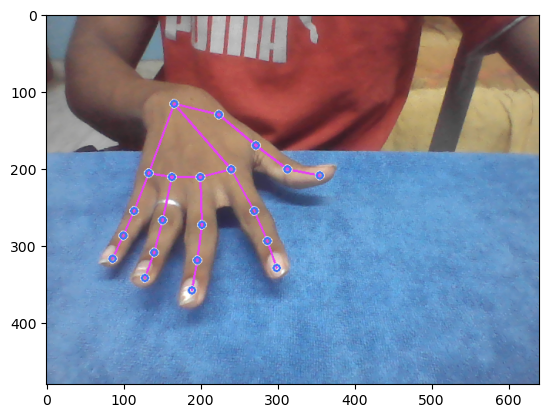

In [13]:
#Shows last frame
draw_styled_landmarks(frame,results)
print_points(results)
print(extract_keypoints(results,image))
plt.imshow(frame)
#This show last frame captured
#Color Conversion
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

### Extract Keypoints

In [14]:
#Obtaining values using list comprenhension
#Takes X and Y coordinate and multiply them with width and height of the image respectively
def extract_keypoints(results,image):
    h,w,c=image.shape
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            points=np.array([[(hand_landmarks.landmark[mp_hands.HandLandmark(i)].x)*w,(hand_landmarks.landmark[mp_hands.HandLandmark(i)].y)*h] for i in range(21)]).flatten()
    else:
        points=np.zeros(42)
    return points

In [15]:
print(len(extract_keypoints(results,image)))

42


### Setup folders for collection

In [16]:
#Path for exported data,Numpyarray
DATA_PATH=os.path.join('MP_data')

#Actions we are going to try to detect
actions=np.array(['No-Tremor','Tremor'])
#100 videos worth of data
no_sequences=100
#Videos are going to be length of 50 frames
sequence_length=50

In [17]:
#Creating folders to save the data
for action in actions:
    for sequence in range(no_sequences):
        try:
            #makedirs will create sub folders
            os.makedirs(os.path.join(DATA_PATH,action,str(sequence)))
        except:
            pass
#We will create 30 folders for every actions

### Collecting data for training and testing

In [18]:
#Accessing video through webcm using OpenCV
#We loop thorugh all frames in camera to create video
cap=cv2.VideoCapture(0)#To acccess our webcam 
#here 0 represents device

#Accessing the holistic model
with mp_hands.Hands(static_image_mode=True,max_num_hands=2,min_detection_confidence=0.5) as hands:
    #Loop through actions:Tremor and non Tremor
    for action in actions:
        #Loop through videos each action 100 videos
        for sequence in range(no_sequences):
            #Loop through each frame per video 50 frames
            for frame_num in range(sequence_length):
                #Read feed
                ret,frame=cap.read()#It reads our frames

                #Make detections
                image,results=mediapipe_detection(frame,hands)

                #Drwing Landmarks
                draw_styled_landmarks(image,results)
                    
                #Applying wait logic 
                #To give break between videos and say to user what video he is at
                if frame_num==0:
                    cv2.putText(image,'STARTING COLLECION',(120,200),
                                   cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),4,cv2.LINE_AA)
                    cv2.putText(image,f'Collecting frames for {action} Video number {sequence}'
                                    ,(15,12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    cv2.waitKey(2000)#This waits for 2 second after every video captured
                    
                else:
                    cv2.putText(image,f'Collecting frames for {action} Video number {sequence}'
                                    ,(15,12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)

                #Extracting the keypoints
                keypoints=extract_keypoints(results,image)
                #Saving the extracted keypoints
                #Path to save the key points
                npy_path=os.path.join(DATA_PATH,action,str(sequence),str(frame_num))
                #Saving keypoints
                np.save(npy_path,keypoints)
                bounding_box(image,results)#To print a Box around the Hand    
                #To show to screen
                #Rendering
                cv2.imshow("OpenCv Feed",image)

                #To Exit o break the feed
                if cv2.waitKey(10) & 0xFF==ord('q'):
                    break #it waits and if we press q breaks the loop
    cap.release()#It releases the webcam
    cv2.destroyAllWindows()#Destroy the cv window

In [13]:
#To destroy open cv in middle
cap.release()#It releases the webcam
cv2.destroyAllWindows()#Destroy the cv window

###  Calculating change of length in points

In [19]:
#Calculates the change for all frames
for action in actions:
    for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                frames={}
                #Collects all frames in a single sequence and save it in a dictionary
                for frame in range(50):
                    npy_path=os.path.join(DATA_PATH,action,str(sequence),f"{frame}.npy")
                    frames[frame]=np.load(npy_path)
                
                npy_path=os.path.join(DATA_PATH,action,str(sequence),"Length")
                
                l=[]
                #Calculate the length for all 50 frames in respective sequence and save it
                for i in range(50):
                    for j in range(i+1,50):
                        frame1,frame2=frames[i],frames[j]
                        for k in range(0,42,2):
                            x1,x2,y1,y2=frame1[k],frame2[k],frame1[k+1],frame2[k+1]
                            l.append(findDistance(x1,x2,y1,y2))
                #Saving keypoints
            print(npy_path)
            np.save(npy_path,l)

MP_data\No-Tremor\0\Length
MP_data\No-Tremor\1\Length
MP_data\No-Tremor\2\Length
MP_data\No-Tremor\3\Length
MP_data\No-Tremor\4\Length
MP_data\No-Tremor\5\Length
MP_data\No-Tremor\6\Length
MP_data\No-Tremor\7\Length
MP_data\No-Tremor\8\Length
MP_data\No-Tremor\9\Length
MP_data\No-Tremor\10\Length
MP_data\No-Tremor\11\Length
MP_data\No-Tremor\12\Length
MP_data\No-Tremor\13\Length
MP_data\No-Tremor\14\Length
MP_data\No-Tremor\15\Length
MP_data\No-Tremor\16\Length
MP_data\No-Tremor\17\Length
MP_data\No-Tremor\18\Length
MP_data\No-Tremor\19\Length
MP_data\No-Tremor\20\Length
MP_data\No-Tremor\21\Length
MP_data\No-Tremor\22\Length
MP_data\No-Tremor\23\Length
MP_data\No-Tremor\24\Length
MP_data\No-Tremor\25\Length
MP_data\No-Tremor\26\Length
MP_data\No-Tremor\27\Length
MP_data\No-Tremor\28\Length
MP_data\No-Tremor\29\Length
MP_data\No-Tremor\30\Length
MP_data\No-Tremor\31\Length
MP_data\No-Tremor\32\Length
MP_data\No-Tremor\33\Length
MP_data\No-Tremor\34\Length
MP_data\No-Tremor\35\Length
MP

In [ ]:
#Calculate length change for y
Data_path="Data"
frames={}
for i in range(sequence_length):
    for frame in range(50):
        npy_path=os.path.join(Data_path,f"{frame}.npy")
        frames[frame]=np.load(npy_path)
npy_path=os.path.join(Data_path,"Length_Y")
l=[]
#Calculate the length for all 50 frames in respective sequence and save it
for i in range(50):
    for j in range(i+1,50):
        frame1,frame2=frames[i],frames[j]
        for k in range(1,42,2):
            y1,y2=frame1[k],frame2[k]
            l.append(findDistance_y(y1,y2))
np.save(npy_path,l)

In [21]:
for i in range(0,len(l)):
    print(l[i])

12.02050424686151
11.451141889004708
12.307307561292536
19.47755281396442
24.06884943183795
7.407142234340025
4.883826519580826
9.322165525865632
12.414946767154142
9.742718914370455
7.674917779241063
7.752261562409205
9.200603459177453
11.711635503816376
13.047267413031308
6.710109847271204
1.1552449588460996
13.823398312180197
15.21991187756012
13.962825556750518
12.533967891670239
12.02050424686151
11.451141889004708
12.307307561292536
19.47755281396442
24.06884943183795
7.407142234340025
4.883826519580826
9.322165525865632
12.414946767154142
9.742718914370455
7.674917779241063
7.752261562409205
9.200603459177453
11.711635503816376
13.047267413031308
6.710109847271204
1.1552449588460996
13.823398312180197
15.21991187756012
13.962825556750518
12.533967891670239
12.02050424686151
11.451141889004708
12.307307561292536
19.47755281396442
24.06884943183795
7.407142234340025
4.883826519580826
9.322165525865632
12.414946767154142
9.742718914370455
7.674917779241063
7.752261562409205
9.20060

In [22]:
t=np.load(os.path.join(DATA_PATH,"Tremor","25","Length.npy"))
nt=np.load(os.path.join(DATA_PATH,"No-Tremor","25","Length.npy"))

In [23]:
len(t)

25725

In [24]:
print(statistics.mode(nt))
print(statistics.mode(t))

0.0
0.0


In [25]:
print(statistics.mean(nt))
print(statistics.mean(t))

2.2477206975551747
12.877428065484851


In [26]:
print(max(nt))
print(max(t))

9.031799915023326
161.5132990811412


### Preprocessing Data and Creating Labels

In [27]:
#Creating label map
label_map={label:num for num,label in enumerate(actions)}

In [28]:
label_map
#We created dictionary for labels with set of id

{'No-Tremor': 0, 'Tremor': 1}

In [29]:
#In preprocessing we put every frame np file in single one

In [30]:
#Creating 2 blank arrays
sequences,labels=[],[]
#here sequences represent our feature data(x) and labels represent labels(y)
#Going through our actions
for action in actions:
    #Going through our 100 videos
    for sequence in range(no_sequences):
        #Creating a blank array window
        window=[]
        #Going through each frames
        for frame_num in range(sequence_length):
            #Loading up the respective frame using np.load()
            res=np.load(os.path.join(DATA_PATH,action,str(sequence),f"Length.npy"))
            #Adding the value to the window array
            print(res)
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

[2.3195778  3.18079842 2.05470423 ... 4.16368964 3.50945188 4.38900602]
[2.3195778  3.18079842 2.05470423 ... 4.16368964 3.50945188 4.38900602]
[2.3195778  3.18079842 2.05470423 ... 4.16368964 3.50945188 4.38900602]
[2.3195778  3.18079842 2.05470423 ... 4.16368964 3.50945188 4.38900602]
[2.3195778  3.18079842 2.05470423 ... 4.16368964 3.50945188 4.38900602]
[2.3195778  3.18079842 2.05470423 ... 4.16368964 3.50945188 4.38900602]
[2.3195778  3.18079842 2.05470423 ... 4.16368964 3.50945188 4.38900602]
[2.3195778  3.18079842 2.05470423 ... 4.16368964 3.50945188 4.38900602]
[2.3195778  3.18079842 2.05470423 ... 4.16368964 3.50945188 4.38900602]
[2.3195778  3.18079842 2.05470423 ... 4.16368964 3.50945188 4.38900602]
[2.3195778  3.18079842 2.05470423 ... 4.16368964 3.50945188 4.38900602]
[2.3195778  3.18079842 2.05470423 ... 4.16368964 3.50945188 4.38900602]
[2.3195778  3.18079842 2.05470423 ... 4.16368964 3.50945188 4.38900602]
[2.3195778  3.18079842 2.05470423 ... 4.16368964 3.50945188 4.38

[2.60079296 3.92932383 3.10536774 ... 0.         0.         0.        ]
[2.60079296 3.92932383 3.10536774 ... 0.         0.         0.        ]
[2.60079296 3.92932383 3.10536774 ... 0.         0.         0.        ]
[2.60079296 3.92932383 3.10536774 ... 0.         0.         0.        ]
[0.94101596 4.82998213 8.33533163 ... 0.         0.         0.        ]
[0.94101596 4.82998213 8.33533163 ... 0.         0.         0.        ]
[0.94101596 4.82998213 8.33533163 ... 0.         0.         0.        ]
[0.94101596 4.82998213 8.33533163 ... 0.         0.         0.        ]
[0.94101596 4.82998213 8.33533163 ... 0.         0.         0.        ]
[0.94101596 4.82998213 8.33533163 ... 0.         0.         0.        ]
[0.94101596 4.82998213 8.33533163 ... 0.         0.         0.        ]
[0.94101596 4.82998213 8.33533163 ... 0.         0.         0.        ]
[0.94101596 4.82998213 8.33533163 ... 0.         0.         0.        ]
[0.94101596 4.82998213 8.33533163 ... 0.         0.         0.  

[8.33348171 4.87859808 4.66260946 ... 0.         0.         0.        ]
[8.33348171 4.87859808 4.66260946 ... 0.         0.         0.        ]
[8.33348171 4.87859808 4.66260946 ... 0.         0.         0.        ]
[8.33348171 4.87859808 4.66260946 ... 0.         0.         0.        ]
[8.33348171 4.87859808 4.66260946 ... 0.         0.         0.        ]
[8.33348171 4.87859808 4.66260946 ... 0.         0.         0.        ]
[1.54833659 1.78476866 1.37021481 ... 1.69428805 1.0267908  1.27530549]
[1.54833659 1.78476866 1.37021481 ... 1.69428805 1.0267908  1.27530549]
[1.54833659 1.78476866 1.37021481 ... 1.69428805 1.0267908  1.27530549]
[1.54833659 1.78476866 1.37021481 ... 1.69428805 1.0267908  1.27530549]
[1.54833659 1.78476866 1.37021481 ... 1.69428805 1.0267908  1.27530549]
[1.54833659 1.78476866 1.37021481 ... 1.69428805 1.0267908  1.27530549]
[1.54833659 1.78476866 1.37021481 ... 1.69428805 1.0267908  1.27530549]
[1.54833659 1.78476866 1.37021481 ... 1.69428805 1.0267908  1.27

[8.18519282 7.72805867 8.55533556 ... 0.         0.         0.        ]
[8.18519282 7.72805867 8.55533556 ... 0.         0.         0.        ]
[8.18519282 7.72805867 8.55533556 ... 0.         0.         0.        ]
[8.18519282 7.72805867 8.55533556 ... 0.         0.         0.        ]
[8.18519282 7.72805867 8.55533556 ... 0.         0.         0.        ]
[8.18519282 7.72805867 8.55533556 ... 0.         0.         0.        ]
[8.18519282 7.72805867 8.55533556 ... 0.         0.         0.        ]
[8.18519282 7.72805867 8.55533556 ... 0.         0.         0.        ]
[8.18519282 7.72805867 8.55533556 ... 0.         0.         0.        ]
[8.18519282 7.72805867 8.55533556 ... 0.         0.         0.        ]
[8.18519282 7.72805867 8.55533556 ... 0.         0.         0.        ]
[8.18519282 7.72805867 8.55533556 ... 0.         0.         0.        ]
[8.18519282 7.72805867 8.55533556 ... 0.         0.         0.        ]
[8.18519282 7.72805867 8.55533556 ... 0.         0.         0.  

[11.08606573 11.35853455  8.85519547 ...  0.          0.
  0.        ]
[11.08606573 11.35853455  8.85519547 ...  0.          0.
  0.        ]
[11.08606573 11.35853455  8.85519547 ...  0.          0.
  0.        ]
[11.08606573 11.35853455  8.85519547 ...  0.          0.
  0.        ]
[11.08606573 11.35853455  8.85519547 ...  0.          0.
  0.        ]
[11.08606573 11.35853455  8.85519547 ...  0.          0.
  0.        ]
[11.08606573 11.35853455  8.85519547 ...  0.          0.
  0.        ]
[11.08606573 11.35853455  8.85519547 ...  0.          0.
  0.        ]
[11.08606573 11.35853455  8.85519547 ...  0.          0.
  0.        ]
[11.08606573 11.35853455  8.85519547 ...  0.          0.
  0.        ]
[11.08606573 11.35853455  8.85519547 ...  0.          0.
  0.        ]
[11.08606573 11.35853455  8.85519547 ...  0.          0.
  0.        ]
[11.08606573 11.35853455  8.85519547 ...  0.          0.
  0.        ]
[11.08606573 11.35853455  8.85519547 ...  0.          0.
  0.        ]
[11.08

[3.5752272  3.47144418 6.20234749 ... 1.63177859 3.09367169 3.66282422]
[3.5752272  3.47144418 6.20234749 ... 1.63177859 3.09367169 3.66282422]
[3.5752272  3.47144418 6.20234749 ... 1.63177859 3.09367169 3.66282422]
[3.5752272  3.47144418 6.20234749 ... 1.63177859 3.09367169 3.66282422]
[3.5752272  3.47144418 6.20234749 ... 1.63177859 3.09367169 3.66282422]
[3.5752272  3.47144418 6.20234749 ... 1.63177859 3.09367169 3.66282422]
[3.5752272  3.47144418 6.20234749 ... 1.63177859 3.09367169 3.66282422]
[3.5752272  3.47144418 6.20234749 ... 1.63177859 3.09367169 3.66282422]
[3.5752272  3.47144418 6.20234749 ... 1.63177859 3.09367169 3.66282422]
[3.5752272  3.47144418 6.20234749 ... 1.63177859 3.09367169 3.66282422]
[3.5752272  3.47144418 6.20234749 ... 1.63177859 3.09367169 3.66282422]
[3.5752272  3.47144418 6.20234749 ... 1.63177859 3.09367169 3.66282422]
[3.5752272  3.47144418 6.20234749 ... 1.63177859 3.09367169 3.66282422]
[3.5752272  3.47144418 6.20234749 ... 1.63177859 3.09367169 3.66

[0.32609688 0.30074477 1.38300314 ... 3.34188733 3.1581073  3.45698089]
[0.32609688 0.30074477 1.38300314 ... 3.34188733 3.1581073  3.45698089]
[0.32609688 0.30074477 1.38300314 ... 3.34188733 3.1581073  3.45698089]
[0.32609688 0.30074477 1.38300314 ... 3.34188733 3.1581073  3.45698089]
[0.32609688 0.30074477 1.38300314 ... 3.34188733 3.1581073  3.45698089]
[0.32609688 0.30074477 1.38300314 ... 3.34188733 3.1581073  3.45698089]
[0.32609688 0.30074477 1.38300314 ... 3.34188733 3.1581073  3.45698089]
[0.32609688 0.30074477 1.38300314 ... 3.34188733 3.1581073  3.45698089]
[0.32609688 0.30074477 1.38300314 ... 3.34188733 3.1581073  3.45698089]
[0.32609688 0.30074477 1.38300314 ... 3.34188733 3.1581073  3.45698089]
[0.32609688 0.30074477 1.38300314 ... 3.34188733 3.1581073  3.45698089]
[0.32609688 0.30074477 1.38300314 ... 3.34188733 3.1581073  3.45698089]
[0.32609688 0.30074477 1.38300314 ... 3.34188733 3.1581073  3.45698089]
[0.32609688 0.30074477 1.38300314 ... 3.34188733 3.1581073  3.45

[14.01589026 14.04524489  9.88313681 ...  0.          0.
  0.        ]
[14.01589026 14.04524489  9.88313681 ...  0.          0.
  0.        ]
[14.01589026 14.04524489  9.88313681 ...  0.          0.
  0.        ]
[14.01589026 14.04524489  9.88313681 ...  0.          0.
  0.        ]
[14.01589026 14.04524489  9.88313681 ...  0.          0.
  0.        ]
[14.01589026 14.04524489  9.88313681 ...  0.          0.
  0.        ]
[14.01589026 14.04524489  9.88313681 ...  0.          0.
  0.        ]
[14.01589026 14.04524489  9.88313681 ...  0.          0.
  0.        ]
[14.01589026 14.04524489  9.88313681 ...  0.          0.
  0.        ]
[14.01589026 14.04524489  9.88313681 ...  0.          0.
  0.        ]
[14.01589026 14.04524489  9.88313681 ...  0.          0.
  0.        ]
[14.01589026 14.04524489  9.88313681 ...  0.          0.
  0.        ]
[14.01589026 14.04524489  9.88313681 ...  0.          0.
  0.        ]
[14.01589026 14.04524489  9.88313681 ...  0.          0.
  0.        ]
[14.01

[4.27809766 2.3612037  0.89676276 ... 0.79985838 2.15817426 2.36012158]
[4.27809766 2.3612037  0.89676276 ... 0.79985838 2.15817426 2.36012158]
[4.27809766 2.3612037  0.89676276 ... 0.79985838 2.15817426 2.36012158]
[4.27809766 2.3612037  0.89676276 ... 0.79985838 2.15817426 2.36012158]
[4.27809766 2.3612037  0.89676276 ... 0.79985838 2.15817426 2.36012158]
[4.27809766 2.3612037  0.89676276 ... 0.79985838 2.15817426 2.36012158]
[4.27809766 2.3612037  0.89676276 ... 0.79985838 2.15817426 2.36012158]
[4.27809766 2.3612037  0.89676276 ... 0.79985838 2.15817426 2.36012158]
[4.27809766 2.3612037  0.89676276 ... 0.79985838 2.15817426 2.36012158]
[4.27809766 2.3612037  0.89676276 ... 0.79985838 2.15817426 2.36012158]
[4.27809766 2.3612037  0.89676276 ... 0.79985838 2.15817426 2.36012158]
[4.27809766 2.3612037  0.89676276 ... 0.79985838 2.15817426 2.36012158]
[4.27809766 2.3612037  0.89676276 ... 0.79985838 2.15817426 2.36012158]
[4.27809766 2.3612037  0.89676276 ... 0.79985838 2.15817426 2.36

[79.27602715 58.81314245 51.45882147 ...  1.72817057  1.61352523
  1.25652978]
[79.27602715 58.81314245 51.45882147 ...  1.72817057  1.61352523
  1.25652978]
[79.27602715 58.81314245 51.45882147 ...  1.72817057  1.61352523
  1.25652978]
[79.27602715 58.81314245 51.45882147 ...  1.72817057  1.61352523
  1.25652978]
[79.27602715 58.81314245 51.45882147 ...  1.72817057  1.61352523
  1.25652978]
[79.27602715 58.81314245 51.45882147 ...  1.72817057  1.61352523
  1.25652978]
[79.27602715 58.81314245 51.45882147 ...  1.72817057  1.61352523
  1.25652978]
[79.27602715 58.81314245 51.45882147 ...  1.72817057  1.61352523
  1.25652978]
[79.27602715 58.81314245 51.45882147 ...  1.72817057  1.61352523
  1.25652978]
[79.27602715 58.81314245 51.45882147 ...  1.72817057  1.61352523
  1.25652978]
[79.27602715 58.81314245 51.45882147 ...  1.72817057  1.61352523
  1.25652978]
[79.27602715 58.81314245 51.45882147 ...  1.72817057  1.61352523
  1.25652978]
[79.27602715 58.81314245 51.45882147 ...  1.72817057

[3.78554046 2.13250419 2.5281771  ... 0.         0.         0.        ]
[3.78554046 2.13250419 2.5281771  ... 0.         0.         0.        ]
[3.78554046 2.13250419 2.5281771  ... 0.         0.         0.        ]
[3.78554046 2.13250419 2.5281771  ... 0.         0.         0.        ]
[3.78554046 2.13250419 2.5281771  ... 0.         0.         0.        ]
[3.78554046 2.13250419 2.5281771  ... 0.         0.         0.        ]
[3.78554046 2.13250419 2.5281771  ... 0.         0.         0.        ]
[3.78554046 2.13250419 2.5281771  ... 0.         0.         0.        ]
[3.78554046 2.13250419 2.5281771  ... 0.         0.         0.        ]
[3.78554046 2.13250419 2.5281771  ... 0.         0.         0.        ]
[3.78554046 2.13250419 2.5281771  ... 0.         0.         0.        ]
[3.78554046 2.13250419 2.5281771  ... 0.         0.         0.        ]
[3.78554046 2.13250419 2.5281771  ... 0.         0.         0.        ]
[3.78554046 2.13250419 2.5281771  ... 0.         0.         0.  

[5.26635211 7.47947004 7.38724732 ... 0.81911834 1.14768616 1.54137014]
[5.26635211 7.47947004 7.38724732 ... 0.81911834 1.14768616 1.54137014]
[5.26635211 7.47947004 7.38724732 ... 0.81911834 1.14768616 1.54137014]
[5.26635211 7.47947004 7.38724732 ... 0.81911834 1.14768616 1.54137014]
[5.26635211 7.47947004 7.38724732 ... 0.81911834 1.14768616 1.54137014]
[5.26635211 7.47947004 7.38724732 ... 0.81911834 1.14768616 1.54137014]
[5.26635211 7.47947004 7.38724732 ... 0.81911834 1.14768616 1.54137014]
[5.26635211 7.47947004 7.38724732 ... 0.81911834 1.14768616 1.54137014]
[5.26635211 7.47947004 7.38724732 ... 0.81911834 1.14768616 1.54137014]
[5.26635211 7.47947004 7.38724732 ... 0.81911834 1.14768616 1.54137014]
[5.26635211 7.47947004 7.38724732 ... 0.81911834 1.14768616 1.54137014]
[5.26635211 7.47947004 7.38724732 ... 0.81911834 1.14768616 1.54137014]
[11.5338759   8.88271794 10.96131812 ...  0.          0.
  0.        ]
[11.5338759   8.88271794 10.96131812 ...  0.          0.
  0.    

[6.67170041 7.47935597 8.7844488  ... 2.05931138 4.25501654 6.27878028]
[6.67170041 7.47935597 8.7844488  ... 2.05931138 4.25501654 6.27878028]
[6.67170041 7.47935597 8.7844488  ... 2.05931138 4.25501654 6.27878028]
[6.67170041 7.47935597 8.7844488  ... 2.05931138 4.25501654 6.27878028]
[6.67170041 7.47935597 8.7844488  ... 2.05931138 4.25501654 6.27878028]
[6.67170041 7.47935597 8.7844488  ... 2.05931138 4.25501654 6.27878028]
[6.67170041 7.47935597 8.7844488  ... 2.05931138 4.25501654 6.27878028]
[6.67170041 7.47935597 8.7844488  ... 2.05931138 4.25501654 6.27878028]
[6.67170041 7.47935597 8.7844488  ... 2.05931138 4.25501654 6.27878028]
[6.67170041 7.47935597 8.7844488  ... 2.05931138 4.25501654 6.27878028]
[6.67170041 7.47935597 8.7844488  ... 2.05931138 4.25501654 6.27878028]
[6.67170041 7.47935597 8.7844488  ... 2.05931138 4.25501654 6.27878028]
[6.67170041 7.47935597 8.7844488  ... 2.05931138 4.25501654 6.27878028]
[6.67170041 7.47935597 8.7844488  ... 2.05931138 4.25501654 6.27

[ 4.79196429  8.04442064 11.0761447  ...  3.88803927  2.8018395
  1.61712073]
[ 4.79196429  8.04442064 11.0761447  ...  3.88803927  2.8018395
  1.61712073]
[ 4.79196429  8.04442064 11.0761447  ...  3.88803927  2.8018395
  1.61712073]
[ 4.79196429  8.04442064 11.0761447  ...  3.88803927  2.8018395
  1.61712073]
[ 4.79196429  8.04442064 11.0761447  ...  3.88803927  2.8018395
  1.61712073]
[ 4.79196429  8.04442064 11.0761447  ...  3.88803927  2.8018395
  1.61712073]
[ 4.79196429  8.04442064 11.0761447  ...  3.88803927  2.8018395
  1.61712073]
[ 4.79196429  8.04442064 11.0761447  ...  3.88803927  2.8018395
  1.61712073]
[ 4.79196429  8.04442064 11.0761447  ...  3.88803927  2.8018395
  1.61712073]
[ 4.79196429  8.04442064 11.0761447  ...  3.88803927  2.8018395
  1.61712073]
[ 4.79196429  8.04442064 11.0761447  ...  3.88803927  2.8018395
  1.61712073]
[ 4.79196429  8.04442064 11.0761447  ...  3.88803927  2.8018395
  1.61712073]
[ 4.79196429  8.04442064 11.0761447  ...  3.88803927  2.8018395


[7.35098148 5.14162159 7.18080941 ... 0.         0.         0.        ]
[7.35098148 5.14162159 7.18080941 ... 0.         0.         0.        ]
[7.35098148 5.14162159 7.18080941 ... 0.         0.         0.        ]
[7.35098148 5.14162159 7.18080941 ... 0.         0.         0.        ]
[7.35098148 5.14162159 7.18080941 ... 0.         0.         0.        ]
[7.35098148 5.14162159 7.18080941 ... 0.         0.         0.        ]
[7.35098148 5.14162159 7.18080941 ... 0.         0.         0.        ]
[7.35098148 5.14162159 7.18080941 ... 0.         0.         0.        ]
[7.35098148 5.14162159 7.18080941 ... 0.         0.         0.        ]
[7.35098148 5.14162159 7.18080941 ... 0.         0.         0.        ]
[7.35098148 5.14162159 7.18080941 ... 0.         0.         0.        ]
[7.35098148 5.14162159 7.18080941 ... 0.         0.         0.        ]
[7.35098148 5.14162159 7.18080941 ... 0.         0.         0.        ]
[7.35098148 5.14162159 7.18080941 ... 0.         0.         0.  

[2.71930324 4.12592552 8.80064736 ... 0.         0.         0.        ]
[2.71930324 4.12592552 8.80064736 ... 0.         0.         0.        ]
[2.71930324 4.12592552 8.80064736 ... 0.         0.         0.        ]
[2.71930324 4.12592552 8.80064736 ... 0.         0.         0.        ]
[2.71930324 4.12592552 8.80064736 ... 0.         0.         0.        ]
[2.71930324 4.12592552 8.80064736 ... 0.         0.         0.        ]
[2.71930324 4.12592552 8.80064736 ... 0.         0.         0.        ]
[2.71930324 4.12592552 8.80064736 ... 0.         0.         0.        ]
[2.71930324 4.12592552 8.80064736 ... 0.         0.         0.        ]
[2.71930324 4.12592552 8.80064736 ... 0.         0.         0.        ]
[2.71930324 4.12592552 8.80064736 ... 0.         0.         0.        ]
[2.71930324 4.12592552 8.80064736 ... 0.         0.         0.        ]
[2.71930324 4.12592552 8.80064736 ... 0.         0.         0.        ]
[2.71930324 4.12592552 8.80064736 ... 0.         0.         0.  

[2.881472   1.45984437 2.9569635  ... 3.12637182 2.70749171 2.74248134]
[2.881472   1.45984437 2.9569635  ... 3.12637182 2.70749171 2.74248134]
[2.881472   1.45984437 2.9569635  ... 3.12637182 2.70749171 2.74248134]
[2.881472   1.45984437 2.9569635  ... 3.12637182 2.70749171 2.74248134]
[2.881472   1.45984437 2.9569635  ... 3.12637182 2.70749171 2.74248134]
[2.881472   1.45984437 2.9569635  ... 3.12637182 2.70749171 2.74248134]
[2.881472   1.45984437 2.9569635  ... 3.12637182 2.70749171 2.74248134]
[2.881472   1.45984437 2.9569635  ... 3.12637182 2.70749171 2.74248134]
[2.881472   1.45984437 2.9569635  ... 3.12637182 2.70749171 2.74248134]
[2.881472   1.45984437 2.9569635  ... 3.12637182 2.70749171 2.74248134]
[2.881472   1.45984437 2.9569635  ... 3.12637182 2.70749171 2.74248134]
[2.881472   1.45984437 2.9569635  ... 3.12637182 2.70749171 2.74248134]
[2.881472   1.45984437 2.9569635  ... 3.12637182 2.70749171 2.74248134]
[2.881472   1.45984437 2.9569635  ... 3.12637182 2.70749171 2.74

[7.63164405 4.94402766 6.10950711 ... 0.         0.         0.        ]
[7.63164405 4.94402766 6.10950711 ... 0.         0.         0.        ]
[7.63164405 4.94402766 6.10950711 ... 0.         0.         0.        ]
[7.63164405 4.94402766 6.10950711 ... 0.         0.         0.        ]
[7.63164405 4.94402766 6.10950711 ... 0.         0.         0.        ]
[7.63164405 4.94402766 6.10950711 ... 0.         0.         0.        ]
[7.63164405 4.94402766 6.10950711 ... 0.         0.         0.        ]
[19.536423   15.2692587   5.08609616 ...  0.          0.
  0.        ]
[19.536423   15.2692587   5.08609616 ...  0.          0.
  0.        ]
[19.536423   15.2692587   5.08609616 ...  0.          0.
  0.        ]
[19.536423   15.2692587   5.08609616 ...  0.          0.
  0.        ]
[19.536423   15.2692587   5.08609616 ...  0.          0.
  0.        ]
[19.536423   15.2692587   5.08609616 ...  0.          0.
  0.        ]
[19.536423   15.2692587   5.08609616 ...  0.          0.
  0.        ]

[26.69723466 16.28382024  8.39346009 ...  2.2394808   3.63308631
  6.00926712]
[26.69723466 16.28382024  8.39346009 ...  2.2394808   3.63308631
  6.00926712]
[26.69723466 16.28382024  8.39346009 ...  2.2394808   3.63308631
  6.00926712]
[26.69723466 16.28382024  8.39346009 ...  2.2394808   3.63308631
  6.00926712]
[26.69723466 16.28382024  8.39346009 ...  2.2394808   3.63308631
  6.00926712]
[26.69723466 16.28382024  8.39346009 ...  2.2394808   3.63308631
  6.00926712]
[26.69723466 16.28382024  8.39346009 ...  2.2394808   3.63308631
  6.00926712]
[26.69723466 16.28382024  8.39346009 ...  2.2394808   3.63308631
  6.00926712]
[26.69723466 16.28382024  8.39346009 ...  2.2394808   3.63308631
  6.00926712]
[26.69723466 16.28382024  8.39346009 ...  2.2394808   3.63308631
  6.00926712]
[26.69723466 16.28382024  8.39346009 ...  2.2394808   3.63308631
  6.00926712]
[26.69723466 16.28382024  8.39346009 ...  2.2394808   3.63308631
  6.00926712]
[26.69723466 16.28382024  8.39346009 ...  2.2394808 

[7.735139   5.96597832 7.51854329 ... 6.48703291 8.10831746 8.88285657]
[7.735139   5.96597832 7.51854329 ... 6.48703291 8.10831746 8.88285657]
[7.735139   5.96597832 7.51854329 ... 6.48703291 8.10831746 8.88285657]
[7.735139   5.96597832 7.51854329 ... 6.48703291 8.10831746 8.88285657]
[7.735139   5.96597832 7.51854329 ... 6.48703291 8.10831746 8.88285657]
[7.735139   5.96597832 7.51854329 ... 6.48703291 8.10831746 8.88285657]
[7.735139   5.96597832 7.51854329 ... 6.48703291 8.10831746 8.88285657]
[7.735139   5.96597832 7.51854329 ... 6.48703291 8.10831746 8.88285657]
[7.735139   5.96597832 7.51854329 ... 6.48703291 8.10831746 8.88285657]
[7.735139   5.96597832 7.51854329 ... 6.48703291 8.10831746 8.88285657]
[7.735139   5.96597832 7.51854329 ... 6.48703291 8.10831746 8.88285657]
[7.735139   5.96597832 7.51854329 ... 6.48703291 8.10831746 8.88285657]
[7.735139   5.96597832 7.51854329 ... 6.48703291 8.10831746 8.88285657]
[7.735139   5.96597832 7.51854329 ... 6.48703291 8.10831746 8.88

[27.75155857 27.65294971 20.10035136 ...  0.          0.
  0.        ]
[27.75155857 27.65294971 20.10035136 ...  0.          0.
  0.        ]
[27.75155857 27.65294971 20.10035136 ...  0.          0.
  0.        ]
[27.75155857 27.65294971 20.10035136 ...  0.          0.
  0.        ]
[27.75155857 27.65294971 20.10035136 ...  0.          0.
  0.        ]
[27.75155857 27.65294971 20.10035136 ...  0.          0.
  0.        ]
[27.75155857 27.65294971 20.10035136 ...  0.          0.
  0.        ]
[27.75155857 27.65294971 20.10035136 ...  0.          0.
  0.        ]
[27.75155857 27.65294971 20.10035136 ...  0.          0.
  0.        ]
[27.75155857 27.65294971 20.10035136 ...  0.          0.
  0.        ]
[27.75155857 27.65294971 20.10035136 ...  0.          0.
  0.        ]
[27.75155857 27.65294971 20.10035136 ...  0.          0.
  0.        ]
[27.75155857 27.65294971 20.10035136 ...  0.          0.
  0.        ]
[27.75155857 27.65294971 20.10035136 ...  0.          0.
  0.        ]
[27.75

[13.2921531   9.6268729  15.91857755 ...  5.61287813  4.02196355
  2.95948689]
[13.2921531   9.6268729  15.91857755 ...  5.61287813  4.02196355
  2.95948689]
[13.2921531   9.6268729  15.91857755 ...  5.61287813  4.02196355
  2.95948689]
[13.2921531   9.6268729  15.91857755 ...  5.61287813  4.02196355
  2.95948689]
[13.2921531   9.6268729  15.91857755 ...  5.61287813  4.02196355
  2.95948689]
[13.2921531   9.6268729  15.91857755 ...  5.61287813  4.02196355
  2.95948689]
[13.2921531   9.6268729  15.91857755 ...  5.61287813  4.02196355
  2.95948689]
[13.2921531   9.6268729  15.91857755 ...  5.61287813  4.02196355
  2.95948689]
[13.2921531   9.6268729  15.91857755 ...  5.61287813  4.02196355
  2.95948689]
[13.2921531   9.6268729  15.91857755 ...  5.61287813  4.02196355
  2.95948689]
[13.2921531   9.6268729  15.91857755 ...  5.61287813  4.02196355
  2.95948689]
[13.2921531   9.6268729  15.91857755 ...  5.61287813  4.02196355
  2.95948689]
[13.2921531   9.6268729  15.91857755 ...  5.61287813

[2.57940461 2.39158302 4.25377553 ... 0.94512134 2.39945238 5.21336554]
[2.57940461 2.39158302 4.25377553 ... 0.94512134 2.39945238 5.21336554]
[2.57940461 2.39158302 4.25377553 ... 0.94512134 2.39945238 5.21336554]
[2.57940461 2.39158302 4.25377553 ... 0.94512134 2.39945238 5.21336554]
[2.57940461 2.39158302 4.25377553 ... 0.94512134 2.39945238 5.21336554]
[2.57940461 2.39158302 4.25377553 ... 0.94512134 2.39945238 5.21336554]
[2.57940461 2.39158302 4.25377553 ... 0.94512134 2.39945238 5.21336554]
[2.57940461 2.39158302 4.25377553 ... 0.94512134 2.39945238 5.21336554]
[2.57940461 2.39158302 4.25377553 ... 0.94512134 2.39945238 5.21336554]
[2.57940461 2.39158302 4.25377553 ... 0.94512134 2.39945238 5.21336554]
[2.57940461 2.39158302 4.25377553 ... 0.94512134 2.39945238 5.21336554]
[2.57940461 2.39158302 4.25377553 ... 0.94512134 2.39945238 5.21336554]
[2.57940461 2.39158302 4.25377553 ... 0.94512134 2.39945238 5.21336554]
[2.57940461 2.39158302 4.25377553 ... 0.94512134 2.39945238 5.21

[91.99160561 79.32974337 71.09442397 ...  8.75683395  5.17847897
  2.51285861]
[91.99160561 79.32974337 71.09442397 ...  8.75683395  5.17847897
  2.51285861]
[91.99160561 79.32974337 71.09442397 ...  8.75683395  5.17847897
  2.51285861]
[91.99160561 79.32974337 71.09442397 ...  8.75683395  5.17847897
  2.51285861]
[91.99160561 79.32974337 71.09442397 ...  8.75683395  5.17847897
  2.51285861]
[91.99160561 79.32974337 71.09442397 ...  8.75683395  5.17847897
  2.51285861]
[91.99160561 79.32974337 71.09442397 ...  8.75683395  5.17847897
  2.51285861]
[91.99160561 79.32974337 71.09442397 ...  8.75683395  5.17847897
  2.51285861]
[91.99160561 79.32974337 71.09442397 ...  8.75683395  5.17847897
  2.51285861]
[91.99160561 79.32974337 71.09442397 ...  8.75683395  5.17847897
  2.51285861]
[91.99160561 79.32974337 71.09442397 ...  8.75683395  5.17847897
  2.51285861]
[91.99160561 79.32974337 71.09442397 ...  8.75683395  5.17847897
  2.51285861]
[91.99160561 79.32974337 71.09442397 ...  8.75683395

In [31]:
np.save("Sequences-1",sequences)
np.save("Labels-1",labels)

In [36]:
X=np.array(sequences)
X.shape

(200, 50, 25725)

In [37]:
y=to_categorical(labels).astype(int)
y.shape
#Here 
#[1,0]-No Tremor
#[0,1]-Tremor

(200, 2)

In [38]:
len(window[1])

25725

In [39]:
len(sequences)

200

In [40]:
#Forming training and testing partition
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.05,random_state=0)
#10 for test other 190 to train

In [41]:
X_train.shape

(190, 50, 25725)

In [42]:
X_test.shape

(10, 50, 25725)

In [43]:
y_train.shape

(190, 2)

In [44]:
y_test.shape

(10, 2)

### Building and Training LSTM Neural Network

In [45]:
#Tensorboard allow us to moniter our accuracy as it is training
#Create a log directory to setuo tensorboard callbacks
log_dir=os.path.join('Logs-1')
tb_callback=TensorBoard(log_dir=log_dir)

In [46]:
#Initiating the model
model=Sequential()
#Adding 3 sets of LSTM models
model.add(LSTM(64,return_sequences=True,activation='relu',input_shape=(50,25725)))
#LSTM produces the hidden state and cell state for every timestep in the input data,
#thus preserving the temporal relationships between the input timesteps. This is particularly useful when stacking LSTM layers,
#where the second LSTM layer requires the sequence output from the first layer.
model.add(LSTM(128,return_sequences=True,activation='relu'))
model.add(LSTM(64,return_sequences=False,activation='relu'))
#Next layer is dense layer which we dont need to return sequences
#Take a look at andrew ng deeplearing specializations
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(actions.shape[0],activation='softmax'))

In [48]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
#categorical_crossentropy is needed for multi classification model

In [59]:
#Fit and train the model
model.fit(X_train,y_train,epochs=1150,callbacks=[tb_callback])

Epoch 1/1150
6/6 [==============================] - 6s 936ms/step - loss: 46.5232 - categorical_accuracy: 0.5737
Epoch 2/1150
6/6 [==============================] - 5s 851ms/step - loss: 61.1367 - categorical_accuracy: 0.5105
Epoch 3/1150
6/6 [==============================] - 5s 856ms/step - loss: 58.6162 - categorical_accuracy: 0.5947
Epoch 4/1150
6/6 [==============================] - 5s 835ms/step - loss: 50.6730 - categorical_accuracy: 0.5947
Epoch 5/1150
6/6 [==============================] - 5s 918ms/step - loss: 49.9109 - categorical_accuracy: 0.5263
Epoch 6/1150
6/6 [==============================] - 6s 960ms/step - loss: 83.5527 - categorical_accuracy: 0.5053
Epoch 7/1150
6/6 [==============================] - 5s 898ms/step - loss: 52.1801 - categorical_accuracy: 0.5737
Epoch 8/1150
6/6 [==============================] - 6s 941ms/step - loss: 63.0977 - categorical_accuracy: 0.6053
Epoch 9/1150
6/6 [==============================] - 6s 949ms/step - loss: 51.7020 - categorical_

6/6 [==============================] - 5s 881ms/step - loss: 126.0249 - categorical_accuracy: 0.5105
Epoch 73/1150
6/6 [==============================] - 5s 852ms/step - loss: 122.6724 - categorical_accuracy: 0.6000
Epoch 74/1150
6/6 [==============================] - 5s 925ms/step - loss: 109.9504 - categorical_accuracy: 0.5421
Epoch 75/1150
6/6 [==============================] - 6s 1s/step - loss: 87.7252 - categorical_accuracy: 0.5579
Epoch 76/1150
6/6 [==============================] - 6s 1s/step - loss: 61.8761 - categorical_accuracy: 0.5789
Epoch 77/1150
6/6 [==============================] - 6s 972ms/step - loss: 67.1752 - categorical_accuracy: 0.5789
Epoch 78/1150
6/6 [==============================] - 6s 937ms/step - loss: 71.1157 - categorical_accuracy: 0.5737
Epoch 79/1150
6/6 [==============================] - 6s 956ms/step - loss: 79.5740 - categorical_accuracy: 0.4842
Epoch 80/1150
6/6 [==============================] - 6s 962ms/step - loss: 126.9012 - categorical_accurac

6/6 [==============================] - 6s 1s/step - loss: 3.3483 - categorical_accuracy: 0.6947
Epoch 144/1150
6/6 [==============================] - 6s 971ms/step - loss: 4.6639 - categorical_accuracy: 0.6737
Epoch 145/1150
6/6 [==============================] - 6s 1s/step - loss: 35.0203 - categorical_accuracy: 0.6579
Epoch 146/1150
6/6 [==============================] - 6s 996ms/step - loss: 79.0903 - categorical_accuracy: 0.6158
Epoch 147/1150
6/6 [==============================] - 6s 948ms/step - loss: 153.7822 - categorical_accuracy: 0.5895
Epoch 148/1150
6/6 [==============================] - 6s 1000ms/step - loss: 103.6573 - categorical_accuracy: 0.6316
Epoch 149/1150
6/6 [==============================] - 6s 948ms/step - loss: 101.8717 - categorical_accuracy: 0.6421
Epoch 150/1150
6/6 [==============================] - 6s 938ms/step - loss: 17.9867 - categorical_accuracy: 0.5895
Epoch 151/1150
6/6 [==============================] - 6s 933ms/step - loss: 63.0245 - categorical_a

6/6 [==============================] - 7s 1s/step - loss: 25.9952 - categorical_accuracy: 0.6105
Epoch 216/1150
6/6 [==============================] - 7s 1s/step - loss: 16.5901 - categorical_accuracy: 0.6000
Epoch 217/1150
6/6 [==============================] - 7s 1s/step - loss: 15.7553 - categorical_accuracy: 0.6105
Epoch 218/1150
6/6 [==============================] - 7s 1s/step - loss: 21.1246 - categorical_accuracy: 0.5789
Epoch 219/1150
6/6 [==============================] - 7s 1s/step - loss: 23.5566 - categorical_accuracy: 0.5842
Epoch 220/1150
6/6 [==============================] - 7s 1s/step - loss: 26.8278 - categorical_accuracy: 0.6421
Epoch 221/1150
6/6 [==============================] - 7s 1s/step - loss: 21.2953 - categorical_accuracy: 0.6158
Epoch 222/1150
6/6 [==============================] - 7s 1s/step - loss: 18.6780 - categorical_accuracy: 0.6632
Epoch 223/1150
6/6 [==============================] - 6s 1s/step - loss: 17.3751 - categorical_accuracy: 0.5947
Epoch 2

6/6 [==============================] - 5s 821ms/step - loss: 130.2144 - categorical_accuracy: 0.4947
Epoch 287/1150
6/6 [==============================] - 5s 825ms/step - loss: 68.7909 - categorical_accuracy: 0.5316
Epoch 288/1150
6/6 [==============================] - 5s 839ms/step - loss: 71.3052 - categorical_accuracy: 0.5000
Epoch 289/1150
6/6 [==============================] - 5s 825ms/step - loss: 91.9013 - categorical_accuracy: 0.5053
Epoch 290/1150
6/6 [==============================] - 5s 824ms/step - loss: 109.8577 - categorical_accuracy: 0.4947
Epoch 291/1150
6/6 [==============================] - 5s 842ms/step - loss: 107.8510 - categorical_accuracy: 0.4211
Epoch 292/1150
6/6 [==============================] - 5s 822ms/step - loss: 31.5990 - categorical_accuracy: 0.5263
Epoch 293/1150
6/6 [==============================] - 5s 822ms/step - loss: 62.0727 - categorical_accuracy: 0.5368
Epoch 294/1150
6/6 [==============================] - 5s 829ms/step - loss: 35.0787 - catego

6/6 [==============================] - 5s 830ms/step - loss: 9.8686 - categorical_accuracy: 0.6211
Epoch 358/1150
6/6 [==============================] - 5s 829ms/step - loss: 4.3578 - categorical_accuracy: 0.6579
Epoch 359/1150
6/6 [==============================] - 5s 835ms/step - loss: 4.9417 - categorical_accuracy: 0.6632
Epoch 360/1150
6/6 [==============================] - 5s 841ms/step - loss: 18.1047 - categorical_accuracy: 0.5474
Epoch 361/1150
6/6 [==============================] - 5s 846ms/step - loss: 9.8642 - categorical_accuracy: 0.6474
Epoch 362/1150
6/6 [==============================] - 5s 837ms/step - loss: 16.6075 - categorical_accuracy: 0.4789
Epoch 363/1150
6/6 [==============================] - 5s 829ms/step - loss: 11.6598 - categorical_accuracy: 0.5211
Epoch 364/1150
6/6 [==============================] - 5s 821ms/step - loss: 8.4198 - categorical_accuracy: 0.6263
Epoch 365/1150
6/6 [==============================] - 5s 845ms/step - loss: 11.1577 - categorical_ac

6/6 [==============================] - 5s 828ms/step - loss: 4.9816 - categorical_accuracy: 0.6895
Epoch 429/1150
6/6 [==============================] - 5s 855ms/step - loss: 4.9301 - categorical_accuracy: 0.6842
Epoch 430/1150
6/6 [==============================] - 5s 827ms/step - loss: 3.3420 - categorical_accuracy: 0.7000
Epoch 431/1150
6/6 [==============================] - 5s 823ms/step - loss: 5.9988 - categorical_accuracy: 0.6737
Epoch 432/1150
6/6 [==============================] - 5s 837ms/step - loss: 6.6641 - categorical_accuracy: 0.6474
Epoch 433/1150
6/6 [==============================] - 5s 838ms/step - loss: 3.5666 - categorical_accuracy: 0.7000
Epoch 434/1150
6/6 [==============================] - 5s 822ms/step - loss: 3.3626 - categorical_accuracy: 0.6947
Epoch 435/1150
6/6 [==============================] - 5s 827ms/step - loss: 1.5078 - categorical_accuracy: 0.7789
Epoch 436/1150
6/6 [==============================] - 5s 839ms/step - loss: 3.6192 - categorical_accura

Epoch 500/1150
6/6 [==============================] - 5s 848ms/step - loss: 4.0656 - categorical_accuracy: 0.7105
Epoch 501/1150
6/6 [==============================] - 5s 826ms/step - loss: 4.2459 - categorical_accuracy: 0.6947
Epoch 502/1150
6/6 [==============================] - 5s 838ms/step - loss: 4.9560 - categorical_accuracy: 0.6053
Epoch 503/1150
6/6 [==============================] - 5s 847ms/step - loss: 7.8400 - categorical_accuracy: 0.6158
Epoch 504/1150
6/6 [==============================] - 5s 822ms/step - loss: 3.4111 - categorical_accuracy: 0.7526
Epoch 505/1150
6/6 [==============================] - 5s 826ms/step - loss: 3.4477 - categorical_accuracy: 0.6895
Epoch 506/1150
6/6 [==============================] - 5s 843ms/step - loss: 3.1959 - categorical_accuracy: 0.6632
Epoch 507/1150
6/6 [==============================] - 5s 825ms/step - loss: 2.5563 - categorical_accuracy: 0.7474
Epoch 508/1150
6/6 [==============================] - 5s 825ms/step - loss: 2.9211 - cat

6/6 [==============================] - 5s 820ms/step - loss: 1.8530 - categorical_accuracy: 0.7421
Epoch 572/1150
6/6 [==============================] - 5s 850ms/step - loss: 2.6324 - categorical_accuracy: 0.6789
Epoch 573/1150
6/6 [==============================] - 5s 854ms/step - loss: 1.4917 - categorical_accuracy: 0.6895
Epoch 574/1150
6/6 [==============================] - 5s 825ms/step - loss: 1.5688 - categorical_accuracy: 0.7211
Epoch 575/1150
6/6 [==============================] - 5s 828ms/step - loss: 1.3433 - categorical_accuracy: 0.7368
Epoch 576/1150
6/6 [==============================] - 5s 828ms/step - loss: 1.3724 - categorical_accuracy: 0.7105
Epoch 577/1150
6/6 [==============================] - 5s 838ms/step - loss: 1.2696 - categorical_accuracy: 0.7263
Epoch 578/1150
6/6 [==============================] - 5s 828ms/step - loss: 1.4187 - categorical_accuracy: 0.6895
Epoch 579/1150
6/6 [==============================] - 5s 828ms/step - loss: 1.4406 - categorical_accura

Epoch 643/1150
6/6 [==============================] - 5s 851ms/step - loss: 1.3397 - categorical_accuracy: 0.7474
Epoch 644/1150
6/6 [==============================] - 5s 844ms/step - loss: 1.1532 - categorical_accuracy: 0.7368
Epoch 645/1150
6/6 [==============================] - 5s 833ms/step - loss: 1.2222 - categorical_accuracy: 0.7316
Epoch 646/1150
6/6 [==============================] - 5s 828ms/step - loss: 1.2830 - categorical_accuracy: 0.7316
Epoch 647/1150
6/6 [==============================] - 5s 841ms/step - loss: 1.3679 - categorical_accuracy: 0.6737
Epoch 648/1150
6/6 [==============================] - 5s 828ms/step - loss: 1.1774 - categorical_accuracy: 0.7105
Epoch 649/1150
6/6 [==============================] - 5s 823ms/step - loss: 1.5003 - categorical_accuracy: 0.8105
Epoch 650/1150
6/6 [==============================] - 5s 847ms/step - loss: 2.0141 - categorical_accuracy: 0.6684
Epoch 651/1150
6/6 [==============================] - 5s 824ms/step - loss: 1.6051 - cat

6/6 [==============================] - 5s 846ms/step - loss: 2.5758 - categorical_accuracy: 0.7053
Epoch 715/1150
6/6 [==============================] - 5s 822ms/step - loss: 1.3697 - categorical_accuracy: 0.7684
Epoch 716/1150
6/6 [==============================] - 5s 825ms/step - loss: 1.3199 - categorical_accuracy: 0.7263
Epoch 717/1150
6/6 [==============================] - 5s 844ms/step - loss: 1.9827 - categorical_accuracy: 0.6632
Epoch 718/1150
6/6 [==============================] - 5s 824ms/step - loss: 2.1481 - categorical_accuracy: 0.7684
Epoch 719/1150
6/6 [==============================] - 5s 832ms/step - loss: 2.4741 - categorical_accuracy: 0.6789
Epoch 720/1150
6/6 [==============================] - 5s 832ms/step - loss: 1.4150 - categorical_accuracy: 0.6842
Epoch 721/1150
6/6 [==============================] - 5s 841ms/step - loss: 1.6811 - categorical_accuracy: 0.6737
Epoch 722/1150
6/6 [==============================] - 5s 822ms/step - loss: 1.4260 - categorical_accura

Epoch 786/1150
6/6 [==============================] - 5s 827ms/step - loss: 2.8797 - categorical_accuracy: 0.7316
Epoch 787/1150
6/6 [==============================] - 5s 833ms/step - loss: 1.7028 - categorical_accuracy: 0.6895
Epoch 788/1150
6/6 [==============================] - 5s 837ms/step - loss: 2.4103 - categorical_accuracy: 0.6474
Epoch 789/1150
6/6 [==============================] - 5s 826ms/step - loss: 2.1464 - categorical_accuracy: 0.6737
Epoch 790/1150
6/6 [==============================] - 5s 823ms/step - loss: 1.6400 - categorical_accuracy: 0.7053
Epoch 791/1150
6/6 [==============================] - 5s 839ms/step - loss: 1.3578 - categorical_accuracy: 0.7526
Epoch 792/1150
6/6 [==============================] - 5s 820ms/step - loss: 1.6766 - categorical_accuracy: 0.6789
Epoch 793/1150
6/6 [==============================] - 5s 831ms/step - loss: 1.4745 - categorical_accuracy: 0.6789
Epoch 794/1150
6/6 [==============================] - 5s 851ms/step - loss: 2.1338 - cat

6/6 [==============================] - 5s 822ms/step - loss: 2.0926 - categorical_accuracy: 0.7842
Epoch 858/1150
6/6 [==============================] - 5s 848ms/step - loss: 1.6899 - categorical_accuracy: 0.6684
Epoch 859/1150
6/6 [==============================] - 5s 823ms/step - loss: 2.6517 - categorical_accuracy: 0.6632
Epoch 860/1150
6/6 [==============================] - 5s 824ms/step - loss: 1.6957 - categorical_accuracy: 0.7158
Epoch 861/1150
6/6 [==============================] - 5s 843ms/step - loss: 1.3458 - categorical_accuracy: 0.6895
Epoch 862/1150
6/6 [==============================] - 5s 830ms/step - loss: 1.6894 - categorical_accuracy: 0.7895
Epoch 863/1150
6/6 [==============================] - 5s 824ms/step - loss: 1.3942 - categorical_accuracy: 0.7105
Epoch 864/1150
6/6 [==============================] - 5s 828ms/step - loss: 1.9253 - categorical_accuracy: 0.7632
Epoch 865/1150
6/6 [==============================] - 5s 835ms/step - loss: 2.3879 - categorical_accura

Epoch 929/1150
6/6 [==============================] - 5s 837ms/step - loss: 1.1479 - categorical_accuracy: 0.7368
Epoch 930/1150
6/6 [==============================] - 5s 821ms/step - loss: 1.1646 - categorical_accuracy: 0.6842
Epoch 931/1150
6/6 [==============================] - 5s 824ms/step - loss: 1.2696 - categorical_accuracy: 0.7316
Epoch 932/1150
6/6 [==============================] - 5s 838ms/step - loss: 1.1650 - categorical_accuracy: 0.7000
Epoch 933/1150
6/6 [==============================] - 5s 838ms/step - loss: 1.3165 - categorical_accuracy: 0.7316
Epoch 934/1150
6/6 [==============================] - 5s 825ms/step - loss: 1.1467 - categorical_accuracy: 0.6947
Epoch 935/1150
6/6 [==============================] - 5s 851ms/step - loss: 1.1689 - categorical_accuracy: 0.7474
Epoch 936/1150
6/6 [==============================] - 5s 826ms/step - loss: 1.2181 - categorical_accuracy: 0.7158
Epoch 937/1150
6/6 [==============================] - 5s 827ms/step - loss: 1.1339 - cat

6/6 [==============================] - 5s 827ms/step - loss: 1.0315 - categorical_accuracy: 0.7474
Epoch 1001/1150
6/6 [==============================] - 5s 866ms/step - loss: 1.0413 - categorical_accuracy: 0.7211
Epoch 1002/1150
6/6 [==============================] - 5s 848ms/step - loss: 1.0263 - categorical_accuracy: 0.7474
Epoch 1003/1150
6/6 [==============================] - 5s 824ms/step - loss: 1.0543 - categorical_accuracy: 0.7684
Epoch 1004/1150
6/6 [==============================] - 5s 828ms/step - loss: 1.0619 - categorical_accuracy: 0.6737
Epoch 1005/1150
6/6 [==============================] - 5s 847ms/step - loss: 1.1250 - categorical_accuracy: 0.7789
Epoch 1006/1150
6/6 [==============================] - 5s 842ms/step - loss: 1.1822 - categorical_accuracy: 0.6842
Epoch 1007/1150
6/6 [==============================] - 5s 855ms/step - loss: 1.1034 - categorical_accuracy: 0.8105
Epoch 1008/1150
6/6 [==============================] - 5s 840ms/step - loss: 1.0821 - categorica

6/6 [==============================] - 5s 817ms/step - loss: 1.1416 - categorical_accuracy: 0.7263
Epoch 1072/1150
6/6 [==============================] - 5s 835ms/step - loss: 1.1548 - categorical_accuracy: 0.7211
Epoch 1073/1150
6/6 [==============================] - 5s 822ms/step - loss: 1.0569 - categorical_accuracy: 0.7474
Epoch 1074/1150
6/6 [==============================] - 5s 820ms/step - loss: 1.2527 - categorical_accuracy: 0.6947
Epoch 1075/1150
6/6 [==============================] - 5s 834ms/step - loss: 1.1197 - categorical_accuracy: 0.6842
Epoch 1076/1150
6/6 [==============================] - 5s 818ms/step - loss: 1.1625 - categorical_accuracy: 0.7316
Epoch 1077/1150
6/6 [==============================] - 5s 824ms/step - loss: 1.1779 - categorical_accuracy: 0.6895
Epoch 1078/1150
6/6 [==============================] - 5s 825ms/step - loss: 1.3388 - categorical_accuracy: 0.6947
Epoch 1079/1150
6/6 [==============================] - 5s 811ms/step - loss: 1.2120 - categorica

6/6 [==============================] - 5s 813ms/step - loss: 1.2615 - categorical_accuracy: 0.7263
Epoch 1143/1150
6/6 [==============================] - 5s 850ms/step - loss: 1.1444 - categorical_accuracy: 0.7263
Epoch 1144/1150
6/6 [==============================] - 5s 829ms/step - loss: 1.0714 - categorical_accuracy: 0.6895
Epoch 1145/1150
6/6 [==============================] - 5s 820ms/step - loss: 1.2241 - categorical_accuracy: 0.7842
Epoch 1146/1150
6/6 [==============================] - 5s 836ms/step - loss: 1.3774 - categorical_accuracy: 0.6474
Epoch 1147/1150
6/6 [==============================] - 5s 825ms/step - loss: 1.4009 - categorical_accuracy: 0.6368
Epoch 1148/1150
6/6 [==============================] - 5s 812ms/step - loss: 1.4773 - categorical_accuracy: 0.7842
Epoch 1149/1150
6/6 [==============================] - 5s 804ms/step - loss: 1.0580 - categorical_accuracy: 0.6737
Epoch 1150/1150
6/6 [==============================] - 5s 844ms/step - loss: 0.9765 - categorica

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 64)            6602240   
                                                                 
 lstm_1 (LSTM)               (None, 50, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 6756770 (25.78 MB)
Trainable params: 67567

### Save Weights

In [67]:
model.save('action.h5')

C:\Users\Suriya\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [68]:
model.load_weights('action.h5')

### Making Prediction

In [61]:
res=model.predict(X_test)

1/1 [==============================] - 0s 194ms/step


In [62]:
for i in range(0,10):
    print(f"\nPrediction:{actions[np.argmax(res[i])]}\tActual Value:{actions[np.argmax(y_test[i])]}")


Prediction:No-Tremor	Actual Value:No-Tremor

Prediction:No-Tremor	Actual Value:Tremor

Prediction:Tremor	Actual Value:Tremor

Prediction:Tremor	Actual Value:No-Tremor

Prediction:Tremor	Actual Value:Tremor

Prediction:Tremor	Actual Value:Tremor

Prediction:No-Tremor	Actual Value:No-Tremor

Prediction:Tremor	Actual Value:Tremor

Prediction:No-Tremor	Actual Value:No-Tremor

Prediction:Tremor	Actual Value:Tremor


### Evalution using confusion matrix and accuracy

In [63]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 122ms/step


In [64]:
#Extracting the predicted classes
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [65]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[5, 1],
        [1, 3]],

       [[3, 1],
        [1, 5]]], dtype=int64)

In [66]:
accuracy_score(ytrue, yhat)

0.8

### Testing in Realtime

In [57]:
res

array([[6.6170430e-01, 3.3829570e-01],
       [9.9980134e-01, 1.9871556e-04],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.4717396e-28],
       [1.0000000e+00, 3.9789626e-12],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [69]:
#To render the probality
colors=[(245,117,16),(117,245,16)]
#One color for each actions
def prob_viz(res,actions,input_frame,colors):
    output_frame=input_frame.copy()#Copy of the frames
    for num,prob in enumerate(res):
        #Dynamicllay placing the rectangle
        cv2.rectangle(output_frame,(0,60+num*40),(int(prob*100),90+num*40),colors[num],-1)
        cv2.putText(output_frame,actions[num],(0,85+num*40),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
    return output_frame

In [70]:
frames={}
#To return value for prediction convert extracted points
def length(points):
    #Collect the x and y and store in frames
    for i in range(50):
        frames[i]=points[i]
    
    s,l=[],[]
    for i in range(50):
        for j in range(i+1,50):
            frame1,frame2=frames[i],frames[j]
            for k in range(0,42,2):
                x1,x2,y1,y2=frame1[k],frame2[k],frame1[k+1],frame2[k+1]
                l.append(findDistance(x1,x2,y1,y2))
        s.append(l)
    return np.array(s)

In [71]:
frames={}
#To return value for prediction convert extracted points
def length_y(points):
    #Collect the x and y and store in frames
    for i in range(50):
        frames[i]=points[i]
    
    l_y=[]
    for i in range(50):
        for j in range(i+1,50):
            frame1,frame2=frames[i],frames[j]
            for k in range(1,42,2):
                y1,y2=frame1[k],frame2[k]
                l_y.append(findDistance_y(y1,y2))
    return np.array(l_y)

In [29]:
#New detection variables
sequence=[]#Collect 30 frames for prediction
res=[]
sentence=[]#Concatenate our history of detection
threshold=0.9 #To only give result if it is above threshold

#Accessing video through webcm using OpenCV
#We loop thorugh all frames in camera to create video
cap=cv2.VideoCapture(0)#To acccess our webcam 
#here 0 represents device

#Accessing the holistic model
with mp_hands.Hands(static_image_mode=True,max_num_hands=2,min_detection_confidence=0.5) as hands:
    while cap.isOpened():#It checks wheather we are accessing or not
        #Read feed
        ret,frame=cap.read()#It reads our frames
        
        #Make detections
        image,results=mediapipe_detection(frame,hands)
        
        #Drwing Landmarks
        draw_styled_landmarks(image,results)
        
        #Prediction Logic
        keypoints=extract_keypoints(results,image)
        sequence.append(keypoints)
        sequence=sequence[-50:]#Grabs last 50 frames
        
        #Run prediction if only 50 frames collected
        if len(sequence)==50:
            res=model.predict(np.expand_dims(length(sequence),axis=0))[0]
            
            
            #Rendering logic to show prediction in the opencv feed
            #Checking wheather our result is above threshold
            if res[np.argmax(res)]>threshold:
                #Checking because we want to check next sequence
                if len(sentence)>0:
                    #Checking if current action is not equal to last sentence
                    if actions[np.argmax(res)]!=sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence)>1:
                #if sentence is greater than 5 grabbing last 5 value
                sentence=sentence[-1:]
            
        bounding_box(image,results)#To print a Box around the Hand
        #Rendering to show the predection
        cv2.rectangle(image,(0,0),(640,40),(245,117,16),-1)
        cv2.putText(image,' '.join(sentence),(3,30),cv2.FONT_HERSHEY_SIMPLEX,
                       1,(255,255,255),2,cv2.LINE_AA)
        
        #Probabilities
        try:
            image=prob_viz(res,actions,image,colors)
        except TypeError:
            pass
        
        #To showw to screen
        #Rendering
        cv2.imshow("OpenCv Feed",image)

        #To Exit o break the feed
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break #it waits and if we press q breaks the loop
    cap.release()#It releases the webcam
    cv2.destroyAllWindows()#Destroy the cv window

1/1 [==============================] - 0s 32ms/step


In [43]:
#New detection variables
sequence=[]#Collect 30 frames for prediction
sentence=[]#Concatenate our history of detection
threshold=0.9 #To only give result if it is above threshold

#Accessing video through webcm using OpenCV
#We loop thorugh all frames in camera to create video
cap=cv2.VideoCapture(0)#To acccess our webcam 
#here 0 represents device

#Accessing the holistic model
with mp_hands.Hands(static_image_mode=True,max_num_hands=2,min_detection_confidence=0.5) as hands:
    while cap.isOpened():#It checks wheather we are accessing or not
        #Read feed
        ret,frame=cap.read()#It reads our frames
        
        #Make detections
        image,results=mediapipe_detection(frame,hands)
        
        #Drwing Landmarks
        draw_styled_landmarks(image,results)
        
        #Prediction Logic
        keypoints=extract_keypoints(results,image)
        sequence.append(keypoints)
        sequence=sequence[-50:]#Grabs last 50 frames
        
        #Run prediction if only 50 frames collected
        if len(sequence)==50:
            res=model.predict(np.expand_dims(length(sequence),axis=0))[0]
            
            
            #Rendering logic to show prediction in the opencv feed
            #Checking wheather our result is above threshold
            if res[np.argmax(res)]>threshold:
                #Checking because we want to check next sequence
                if(length_y(sequence).mean()>100):
                    pass
                else:
                    if len(sentence)>0:
                        #Checking if current action is not equal to last sentence
                        if actions[np.argmax(res)]!=sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence)>1:
                #if sentence is greater than 5 grabbing last 5 value
                sentence=sentence[-1:]
            
        bounding_box(image,results)#To print a Box around the Hand
        #Rendering to show the predection
        cv2.rectangle(image,(0,0),(640,40),(245,117,16),-1)
        cv2.putText(image,' '.join(sentence),(3,30),cv2.FONT_HERSHEY_SIMPLEX,
                       1,(255,255,255),2,cv2.LINE_AA)
        
        #Probabilities
        try:
            image=prob_viz(res,actions,image,colors)
        except TypeError:
            pass
        
        #To showw to screen
        #Rendering
        cv2.imshow("OpenCv Feed",image)

        #To Exit o break the feed
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break #it waits and if we press q breaks the loop
    cap.release()#It releases the webcam
    cv2.destroyAllWindows()#Destroy the cv window

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


In [ ]:
a=np.array(length_y(sequence))

In [41]:
a.mean()

0.0

In [175]:
a=length(sequence)
a.max()

43.82122364696824

In [30]:
cap.release()#It releases the webcam
cv2.destroyAllWindows()#Destroy the cv window

### Numpy Analysis

In [25]:
a1=np.load(os.path.join('MP_data','No-Tremor','19',"Length.npy"))
a2=np.load(os.path.join('MP_data','No-Tremor','29',"Length.npy"))
a3=np.load(os.path.join('MP_data','No-Tremor','25',"Length.npy"))
a4=np.load(os.path.join('MP_data','No-Tremor','89',"Length.npy"))
a5=np.load(os.path.join('MP_data','No-Tremor','10',"Length.npy"))

In [26]:
b1=np.load(os.path.join('MP_data','Tremor','19',"Length.npy"))
b2=np.load(os.path.join('MP_data','Tremor','29',"Length.npy"))
b3=np.load(os.path.join('MP_data','Tremor','25',"Length.npy"))
b4=np.load(os.path.join('MP_data','Tremor','89',"Length.npy"))
b5=np.load(os.path.join('MP_data','Tremor','10',"Length.npy"))

In [27]:
nt=np.concatenate((a1, a2,a3,a4,a5), axis = 0)
print(f"Mean of NT:{statistics.mean(nt)}")
print(f"Mode of NT:{statistics.mode(nt)}")
print(f"Max of NT:{max(nt)}")
print(f"Min of NT:{min(nt)}")

Mean of NT:1.6681440351010237
Mode of NT:0.0
Max of NT:10.62371296278681
Min of NT:0.0


In [28]:
t=np.concatenate((b1, b2,b3,b4,b5), axis = 0)
print(f"Mean of Tremor:{statistics.mean(t)}")
print(f"Mode of Tremor:{statistics.mode(t)}")
print(f"Max of Tremor:{max(t)}")
print(f"Min of Tremor:{min(t)}")

Mean of Tremor:12.77362175123311
Mode of Tremor:0.0
Max of Tremor:99.29079669701278
Min of Tremor:0.0
